# l_value_finding.ipynb

In [1]:
# 250개의 얼굴 이미지 파일 다운로드하기
from bs4 import BeautifulSoup
import requests
import urllib.request

res = urllib.request.urlopen("https://www.angelicadass.com/humanae-project").read()
soup = BeautifulSoup(res, "lxml")
img_list = soup.find_all("a", {"class" : "image-slide-anchor"})

for i in range(len(img_list)):
    img = img_list[i]
    img_src = img['href']
    file_name = "face_" + str(i) + ".jpg" 
    save_path = "C:/Users/ICT01_03/Documents/Personal_Color/face" + file_name    
    urllib.request.urlretrieve(img_src , save_path) 

KeyboardInterrupt: 

In [1]:
import cv2
import dlib
import numpy
import sys
import matplotlib.pyplot as plt
import math
import io

In [2]:
faceCascade=cv2.CascadeClassifier('C:/opencv-master/data/haarcascades')
PREDICTOR_PATH = "C:/Users/ICT01_03/Documents/Personal_Color/shape_predictor_68_face_landmarks.dat"

FEATHER_AMOUNT = 11
SCALE_FACTOR = 1
# 이거 보니까 캐치톤 ppt(pdf)에서 숫자를 잘못 넣었네. pdf그림상 숫자에서 1씩 빼야 함.
FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))

# Points used to line up the images. 이미지의 포인트 연결
ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS +
                               RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH) # 눈코입 포인트 집어냄

class TooManyFaces(Exception):
    pass

class NoFaces(Exception):
    pass

def annotate_landmarks(im, landmarks):
    im = im.copy()
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(im, str(idx), pos, fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, fontScale=0.4,color=(0, 0, 255))
        cv2.circle(im, pos, 3, color=(0, 255, 255))
    return im

#파일 이름을 매개 변수로 지정하여 이미지를 읽고 랜드 마크를 얻음
def read_im_and_landmarks(fname):
    im = cv2.imread(fname, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (im.shape[1] * SCALE_FACTOR,
                         im.shape[0] * SCALE_FACTOR))
    s = get_landmarks(im)

    return im, s

def get_landmarks(im):
    rects = detector(im, 1)   
    if len(rects) > 1:
        raise TooManyFaces
    if len(rects) == 0:
        raise NoFaces
# 이미지에서 사각형으로 얼굴을 따낸 걸로 눈코입 집어냄. 그 포인트들의 리스트가 parts -> 넘파이 벡터화
    return numpy.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

# rect: dlib rectangle
# parts: list of dlib.point, or a dlib.points object.

In [3]:
# def cut_eyes(filename,landmarks):
#     img = io.imread(filename+'.jpg')
#     lx1=landmarks[0].item(0)
#     lx2=landmarks[27].item(0)
#     ly1=landmarks[37].item(1)+30
    
#     return img[ly2:ly1,lx1:lx2,:]

def cut_eyes(filename,landmarks):
    img =io.imread(filename+'.jpg')
    lx1=landmarks[37].item(0)-2
    lx2=landmarks[28].item(0)+3 # 랜드마크 매트릭스 중 27번 - x좌표값
    ly1=landmarks[37].item(1)+1 # ly2는 왜 없는지. 여기서는 30을 왜 더하는지 이해 안감. y값이니 눈 크기를 최소 30으로 지정한듯?
    ly2=landmarks[40].item(1)+1
    return img[ly1:ly2,lx1:lx2,:]

In [4]:
def select_index_to_use(index_dark, index_medium, index_light):
    max = 0
    name_of_index = ""
    index_to_use = []
    
    if len(index_dark) > len(index_medium):
        max = len(index_dark)
        index_to_use = index_dark
        name_of_index = "Dark"
    else:
        max = len(index_medium)
        index_to_use = index_medium
        name_of_index = "Medium"
        
    if max < len(index_light):
        print("Light")
        index_to_use = index_light
    else:
        print(name_of_index)
        
    return index_to_use

In [5]:
def indexs_per_type(cut_eyes, lower_value, upper_value):

    #Light on eye Detection
    
    %matplotlib inline
    gray = cv2.cvtColor(cut_eyes, cv2.COLOR_BGR2GRAY)
    etval, thresholded = cv2.threshold(gray, upper_value, 255, cv2.THRESH_BINARY)
    
    
    index = []
    i = 0

    while i < cut_eyes.shape[0]:
        j = 0
        index_of_black = []
        while j < cut_eyes.shape[1]:
            if thresholded[i][j] == 0:
                index_of_black.append(i)
                index_of_black.append(j)
                index.append(index_of_black)
                index_of_black = []
            j += 1
        i += 1
        
    etval, thresholded = cv2.threshold(gray, lower_value, 255, cv2.THRESH_BINARY)
    
    i = 0

    while i < cut_eyes.shape[0]:
        j = 0
        index_deleted = []
        while j < cut_eyes.shape[1]:
            if thresholded[i][j] == 0:
                index_deleted.append(i)
                index_deleted.append(j)
                if index_deleted in index:
                    index.remove(index_deleted)
                index_deleted = []
            j += 1
        i += 1
        
    return index

In [6]:
import math

index_dark = []
index_medium = []
index_light = []

def eye_l_value(filename, landmarks):
  
    ## Cut_eyes

    cut_eyes = im[landmarks[37][0, 1]+1:landmarks[40][0, 1]+1, landmarks[37][0, 0]-2:landmarks[38][0, 0]+3, :]

    index_dark = indexs_per_type(cut_eyes, 35, 110)
    index_medium = indexs_per_type(cut_eyes, 50, 140)
    index_light = indexs_per_type(cut_eyes, 65, 150)
    
    index_to_use = select_index_to_use(index_dark, index_medium, index_light)
    
    eye_lab = cv2.cvtColor(cut_eyes, cv2.COLOR_RGB2LAB)
    eye_l_value = []

    i = 0
    while i < len(index_to_use):
        eye_l_value.append(eye_lab[index_to_use[i][0], index_to_use[i][1], 0])
        i += 1

    i = 0
    while i < int(len(eye_l_value)*15/85):
        eye_l_value.append(0)
        i += 1
        
    eye_l_value = np.array(eye_l_value)
    return math.sqrt(np.sum((eye_l_value - np.mean(eye_l_value))**2)/(eye_l_value.size)),eye_l_value.size,cut_eyes

In [7]:
import numpy as np

eyesize = np.array([])
for i in range(249):
    filename = 'C:/Users/ICT01_03/Documents/Personal_Color/face/face_'+str(i)
    print(filename)
    im, landmarks = read_im_and_landmarks(filename+'.jpg')
    origin = im.copy()
    color_location = ((landmarks[54]+landmarks[11]+landmarks[45])/3).astype(int)
    rgb = im[color_location[0, 1], color_location[0, 0]][2],im[color_location[0, 1], color_location[0, 0]][1], im[color_location[0, 1], color_location[0, 0]][0]

    im_annotated = annotate_landmarks(im, landmarks)
    std, leng, eyes = eye_l_value(filename,landmarks) #표준편차, 길이, 눈 좌표
    eyesize = np.append(eyesize,[eyes.shape[1],eyes.shape[0]]) #전체 리스트에 각각의 가로 세로 길이 추가

    print('-------'+str(i+1)+'가로길이: '+str(eyes.shape[1])+', 세로길이: '+str(eyes.shape[0])+'-------')
    print(std,leng,eyes)
    print(rgb)

C:/Users/ICT01_03/Documents/Personal_Color/face/face_0
Medium
-------1가로길이: 16, 세로길이: 10-------
41.86866385168083 103 [[[ 85  85  97]
  [ 49  53  71]
  [ 35  48  70]
  [ 32  43  75]
  [ 23  39  62]
  [ 26  32  51]
  [ 34  29  30]
  [ 36  37  33]
  [ 59  54  51]
  [ 70  63  66]
  [ 46  46  64]
  [ 34  36  66]
  [ 39  45  74]
  [ 62  61  87]
  [ 87  84 100]
  [146 139 144]]

 [[100 101 111]
  [ 54  56  74]
  [ 45  54  81]
  [ 34  48  84]
  [ 26  38  72]
  [ 25  34  61]
  [ 43  40  49]
  [123 115 108]
  [171 165 158]
  [174 170 169]
  [127 131 142]
  [ 54  64  88]
  [ 47  58  85]
  [ 75  73 102]
  [ 97  90 111]
  [157 152 161]]

 [[116 118 128]
  [ 65  68  83]
  [ 53  64  94]
  [ 34  53  91]
  [ 29  44  83]
  [ 32  43  73]
  [ 52  54  72]
  [135 129 130]
  [174 172 172]
  [171 173 173]
  [129 135 146]
  [ 66  77 104]
  [ 61  72 104]
  [ 84  85 113]
  [115 105 122]
  [177 173 184]]

 [[132 133 147]
  [ 84  82  94]
  [ 55  62  87]
  [ 46  58  92]
  [ 36  52  89]
  [ 38  48  78]
  [ 49  53  

Dark
-------5가로길이: 17, 세로길이: 10-------
32.55144405623296 101 [[[ 61  67  80]
  [ 80  84  95]
  [ 51  52  62]
  [ 24  26  36]
  [ 23  25  36]
  [ 22  24  34]
  [ 26  26  32]
  [146 127 122]
  [171 162 149]
  [138 132 119]
  [166 157 144]
  [148 142 135]
  [ 65  64  73]
  [ 23  23  37]
  [ 27  28  38]
  [ 84  77  82]
  [155 153 159]]

 [[123 125 125]
  [116 121 120]
  [ 44  46  54]
  [ 26  29  43]
  [ 27  27  43]
  [ 26  26  38]
  [ 32  29  31]
  [142 126 110]
  [183 172 158]
  [182 171 163]
  [180 165 156]
  [162 153 144]
  [ 54  53  62]
  [ 26  26  44]
  [ 29  30  44]
  [ 67  60  63]
  [181 178 170]]

 [[158 160 154]
  [120 127 122]
  [ 40  43  48]
  [ 27  32  47]
  [ 27  29  47]
  [ 28  28  40]
  [ 30  25  27]
  [ 71  64  55]
  [ 96  87  77]
  [107 101  90]
  [108 101  86]
  [ 96  94  84]
  [ 36  40  45]
  [ 26  31  46]
  [ 25  33  46]
  [ 59  51  62]
  [171 168 164]]

 [[174 178 173]
  [129 135 134]
  [ 44  43  52]
  [ 27  32  47]
  [ 27  31  49]
  [ 26  31  40]
  [ 28  24  29]
  [ 5

Dark
-------9가로길이: 17, 세로길이: 8-------
32.551801708715054 86 [[[ 43  46  51]
  [ 27  30  38]
  [ 23  26  40]
  [ 20  25  34]
  [ 20  24  35]
  [ 19  21  29]
  [ 47  43  42]
  [102  95  92]
  [123 119 118]
  [121 118 114]
  [122 116 111]
  [ 83  84  88]
  [ 23  24  38]
  [ 25  28  42]
  [ 33  34  48]
  [ 84  80  86]
  [120 126 125]]

 [[ 70  74  79]
  [ 30  32  42]
  [ 21  24  39]
  [ 22  25  40]
  [ 20  27  42]
  [ 23  23  29]
  [ 43  36  33]
  [ 65  59  54]
  [ 67  64  60]
  [ 73  69  68]
  [ 86  82  71]
  [ 59  62  66]
  [ 26  29  44]
  [ 22  28  41]
  [ 26  32  45]
  [ 76  68  75]
  [153 157 152]]

 [[ 89  95 102]
  [ 36  37  51]
  [ 23  30  50]
  [ 21  29  46]
  [ 26  27  41]
  [ 23  24  34]
  [ 31  25  26]
  [ 50  45  44]
  [ 60  57  53]
  [ 54  50  49]
  [ 43  39  38]
  [ 29  30  34]
  [ 24  31  46]
  [ 25  30  51]
  [ 34  40  59]
  [ 83  75  85]
  [167 166 168]]

 [[105 113 120]
  [ 43  47  58]
  [ 19  29  46]
  [ 20  28  45]
  [ 22  29  44]
  [ 25  28  43]
  [ 40  35  34]
  [ 91

Medium
-------13가로길이: 16, 세로길이: 9-------
44.855163326905114 144 [[[ 53  58  73]
  [ 53  55  66]
  [ 61  64  69]
  [ 56  63  72]
  [ 52  65  81]
  [ 68  73  88]
  [130 116 117]
  [171 153 142]
  [178 158 147]
  [170 155 152]
  [101 110 124]
  [ 71  87 100]
  [ 90  97 100]
  [ 89  93  94]
  [108 104 109]
  [175 170 172]]

 [[ 65  67  77]
  [ 58  61  66]
  [ 70  67  69]
  [ 66  72  77]
  [ 52  69  82]
  [ 70  73  81]
  [152 132 115]
  [152 136 120]
  [157 137 119]
  [145 131 119]
  [ 82  89 104]
  [ 72  87 103]
  [ 99 106 109]
  [ 95  98 102]
  [ 97  96 100]
  [168 163 164]]

 [[ 67  68  72]
  [ 63  62  64]
  [ 67  65  64]
  [ 65  70  73]
  [ 67  75  92]
  [ 42  49  64]
  [ 64  51  43]
  [ 88  74  68]
  [116  97  90]
  [ 94  84  77]
  [ 71  79  96]
  [ 87 103 119]
  [107 116 120]
  [ 96 105 109]
  [ 95  98 103]
  [163 157 162]]

 [[ 75  74  76]
  [ 78  77  79]
  [ 84  78  79]
  [ 79  78  80]
  [ 82  94 104]
  [ 46  63  82]
  [ 84  69  67]
  [167 142 126]
  [175 154 139]
  [147 134 126]
  

Dark
-------18가로길이: 18, 세로길이: 12-------
32.28106811294204 161 [[[ 80  82  90]
  [ 84  95 103]
  [ 48  54  61]
  [ 30  30  42]
  [ 29  31  39]
  [ 32  32  44]
  [ 81  74  81]
  [ 83  79  84]
  [110 104 105]
  [103  96  99]
  [ 96  90  95]
  [ 99  94  96]
  [ 40  39  48]
  [ 39  38  48]
  [ 62  62  68]
  [120 124 129]
  [111 119 132]
  [106 112 125]]

 [[152 157 160]
  [ 86 100 106]
  [ 37  39  47]
  [ 30  31  45]
  [ 28  31  45]
  [ 30  30  42]
  [ 94  85  88]
  [108 101  98]
  [149 139 132]
  [132 124 124]
  [125 117 117]
  [121 115 116]
  [ 32  34  44]
  [ 32  33  47]
  [ 48  45  54]
  [105 108 113]
  [143 158 167]
  [147 158 166]]

 [[145 157 161]
  [ 59  68  77]
  [ 33  33  47]
  [ 30  34  52]
  [ 29  34  49]
  [ 26  29  43]
  [ 97  88  91]
  [145 134 130]
  [173 162 154]
  [160 152 145]
  [155 146 137]
  [124 121 117]
  [ 26  32  43]
  [ 32  35  49]
  [ 38  36  48]
  [ 75  74  83]
  [128 144 156]
  [172 188 195]]

 [[115 134 139]
  [ 50  53  61]
  [ 32  36  54]
  [ 31  37  56]
  [ 

Medium
-------22가로길이: 17, 세로길이: 10-------
42.336877831150886 140 [[[ 48  45  54]
  [ 47  44  46]
  [ 47  42  44]
  [ 31  29  29]
  [ 30  23  20]
  [ 51  40  36]
  [ 77  65  59]
  [ 80  69  61]
  [ 95  85  75]
  [116 100  88]
  [121 105  88]
  [ 90  78  68]
  [ 32  24  25]
  [ 64  61  63]
  [ 90  86  85]
  [102  95  92]
  [164 159 158]]

 [[ 67  65  65]
  [ 63  60  56]
  [ 37  37  37]
  [ 26  22  21]
  [ 32  25  22]
  [ 34  25  22]
  [ 44  32  28]
  [ 67  51  45]
  [ 83  65  58]
  [106  91  82]
  [ 97  78  73]
  [ 68  54  48]
  [ 38  32  33]
  [ 72  68  67]
  [ 97  98  94]
  [104  98  99]
  [168 156 154]]

 [[ 75  70  69]
  [ 69  67  66]
  [ 49  44  45]
  [ 27  22  21]
  [ 31  24  21]
  [ 41  31  24]
  [ 83  71  61]
  [123 107  91]
  [149 130 115]
  [156 136 125]
  [132 114 103]
  [ 99  84  75]
  [ 57  49  49]
  [ 81  80  76]
  [ 98  95  90]
  [107 102  99]
  [174 165 162]]

 [[ 83  80  76]
  [ 79  76  72]
  [ 57  59  60]
  [ 39  37  36]
  [ 32  25  22]
  [ 41  31  24]
  [ 76  64  52]
 

Dark
-------26가로길이: 17, 세로길이: 11-------
34.92822656185918 129 [[[ 49  58  85]
  [ 49  57  80]
  [ 35  42  59]
  [ 24  32  49]
  [ 21  28  43]
  [ 20  26  39]
  [ 29  29  43]
  [ 42  38  49]
  [ 41  43  51]
  [ 42  44  54]
  [ 41  43  53]
  [ 39  41  59]
  [ 31  38  55]
  [ 38  45  65]
  [ 46  53  78]
  [ 51  65  94]
  [ 65  83 114]]

 [[103 104 114]
  [ 63  66  74]
  [ 23  22  31]
  [ 15  18  23]
  [ 16  18  26]
  [ 18  21  26]
  [ 45  43  49]
  [ 59  57  63]
  [ 77  71  76]
  [ 77  76  80]
  [ 59  58  60]
  [ 27  26  35]
  [ 17  20  25]
  [ 24  24  30]
  [ 47  47  59]
  [ 64  71  88]
  [ 47  59  77]]

 [[116 121 120]
  [ 43  48  49]
  [ 18  20  30]
  [ 21  23  33]
  [ 18  19  29]
  [ 25  24  33]
  [ 93  89  88]
  [114 110 109]
  [131 126 123]
  [118 116 116]
  [ 98  97 101]
  [ 36  38  46]
  [ 16  19  27]
  [ 25  24  33]
  [ 34  34  40]
  [ 97 100 105]
  [115 119 130]]

 [[ 98  99 103]
  [ 31  33  41]
  [ 18  22  33]
  [ 20  23  31]
  [ 17  23  30]
  [ 24  27  32]
  [104  98  93]
  [1

Dark
-------30가로길이: 18, 세로길이: 12-------
35.885423224479325 100 [[[ 56  58  68]
  [ 20  21  25]
  [ 14  15  19]
  [ 15  14  23]
  [ 18  16  22]
  [ 16  14  20]
  [ 38  31  28]
  [ 86  74  70]
  [114 102  98]
  [ 91  83  83]
  [ 72  65  68]
  [ 40  39  41]
  [ 19  18  27]
  [ 15  17  25]
  [ 20  22  33]
  [ 27  30  44]
  [ 28  32  50]
  [ 30  36  55]]

 [[ 47  49  57]
  [ 17  18  22]
  [ 18  18  24]
  [ 18  18  24]
  [ 15  17  25]
  [ 19  13  14]
  [ 90  78  72]
  [147 135 129]
  [170 161 157]
  [154 142 136]
  [128 116 112]
  [ 71  66  68]
  [ 15  18  23]
  [ 18  17  26]
  [ 17  17  23]
  [ 35  34  38]
  [ 79  78  87]
  [ 65  67  78]]

 [[ 35  38  46]
  [ 17  19  27]
  [ 15  18  26]
  [ 17  19  27]
  [ 16  17  21]
  [ 20  15  12]
  [ 95  86  77]
  [125 117 104]
  [129 122 113]
  [134 124 117]
  [126 117 108]
  [ 73  70  65]
  [ 14  15  19]
  [ 20  19  28]
  [ 21  19  25]
  [ 36  32  38]
  [103 103 109]
  [134 140 147]]

 [[ 32  37  46]
  [ 19  21  29]
  [ 16  19  27]
  [ 17  19  29]
  [

Medium
-------34가로길이: 15, 세로길이: 6-------
39.90884675585998 81 [[[ 57  62  77]
  [ 28  38  55]
  [ 32  44  62]
  [ 29  46  72]
  [ 26  43  69]
  [ 31  27  33]
  [ 35  29  30]
  [ 68  59  56]
  [ 93  85  78]
  [ 94  82  80]
  [ 72  65  62]
  [ 37  48  68]
  [ 50  67  93]
  [ 56  70  88]
  [ 53  63  80]]

 [[ 80  86  97]
  [ 29  39  56]
  [ 29  42  68]
  [ 29  45  68]
  [ 30  42  70]
  [ 27  30  45]
  [ 56  47  43]
  [130 118 108]
  [155 145 135]
  [156 144 134]
  [123 115 115]
  [ 56  65  85]
  [ 57  71  90]
  [ 51  68  94]
  [ 59  66  81]]

 [[104 108 119]
  [ 45  49  68]
  [ 35  48  70]
  [ 30  50  75]
  [ 29  48  81]
  [ 35  48  74]
  [ 46  48  56]
  [106  97  88]
  [138 126 114]
  [131 125 118]
  [ 94  98 103]
  [ 52  68  91]
  [ 47  64  83]
  [ 47  58  85]
  [ 66  68  86]]

 [[121 126 141]
  [ 79  84  99]
  [ 36  49  71]
  [ 35  52  73]
  [ 37  52  78]
  [ 41  60  87]
  [ 43  60  87]
  [ 67  73  92]
  [ 87  89 100]
  [ 88  98 116]
  [ 61  77 100]
  [ 55  71  94]
  [ 65  76  96]
  [ 

Light
-------38가로길이: 16, 세로길이: 9-------
52.83167386983768 96 [[[ 95 107 109]
  [101 106 104]
  [ 85  94  91]
  [ 44  49  52]
  [ 92  77  68]
  [177 151 134]
  [190 167 151]
  [189 167 149]
  [171 149 138]
  [142 138 133]
  [127 133 128]
  [125 130 131]
  [115 118 123]
  [164 166 167]
  [189 194 203]
  [178 183 198]]

 [[115 123 123]
  [116 123 120]
  [ 81  92  96]
  [ 37  38  42]
  [ 68  58  48]
  [136 122 104]
  [140 125 109]
  [140 125 106]
  [129 113 100]
  [104  99  96]
  [124 122 121]
  [143 147 141]
  [129 136 133]
  [154 157 162]
  [186 191 206]
  [188 196 209]]

 [[124 125 123]
  [129 129 129]
  [ 91  96  97]
  [ 49  48  52]
  [ 37  33  28]
  [ 68  61  52]
  [ 89  79  72]
  [ 88  77  69]
  [ 57  49  42]
  [ 85  79  80]
  [148 143 140]
  [148 152 146]
  [124 129 130]
  [153 154 164]
  [193 197 208]
  [201 208 217]]

 [[120 126 121]
  [141 147 136]
  [125 123 122]
  [ 73  76  81]
  [ 44  38  39]
  [109  93  80]
  [143 129 111]
  [139 126 112]
  [109  98  90]
  [117 115 115]
  [15

Medium
-------42가로길이: 17, 세로길이: 12-------
44.997790338994264 171 [[[ 84  79  88]
  [ 74  66  66]
  [ 66  61  60]
  [ 75  71  70]
  [ 69  69  69]
  [ 47  39  39]
  [103  84  77]
  [111  94  85]
  [126 107 102]
  [119 101  94]
  [110  96  84]
  [105 100  97]
  [ 73  68  69]
  [ 76  67  63]
  [ 91  78  80]
  [120 109 119]
  [102 102 120]]

 [[ 94  91  87]
  [ 77  69  62]
  [ 76  64  60]
  [ 76  71  70]
  [ 45  43  43]
  [ 40  28  24]
  [137 108  99]
  [157 133 121]
  [175 153 141]
  [159 140 127]
  [140 118 106]
  [112 106 101]
  [ 89  87  87]
  [ 83  72  68]
  [ 92  79  71]
  [145 129 122]
  [179 174 176]]

 [[ 91  85  80]
  [ 76  67  63]
  [ 78  71  68]
  [ 70  70  70]
  [ 34  31  33]
  [ 41  30  26]
  [115  95  84]
  [137 121 105]
  [157 142 126]
  [157 138 123]
  [143 123 106]
  [ 98  87  79]
  [ 79  77  76]
  [ 84  75  71]
  [ 87  76  72]
  [130 118 112]
  [198 189 185]]

 [[ 93  85  78]
  [ 87  73  67]
  [ 83  77  72]
  [ 68  65  67]
  [ 36  27  30]
  [ 41  32  28]
  [ 59  47  41]
 

Light
-------46가로길이: 17, 세로길이: 11-------
52.33772220089991 112 [[[113 111 123]
  [123 121 127]
  [ 91  84  87]
  [ 94  82  80]
  [104  94  87]
  [107  96  92]
  [ 91  81  81]
  [115  98  95]
  [140 127 119]
  [162 144 137]
  [181 163 152]
  [155 142 134]
  [124 111 109]
  [115 104 100]
  [146 135 131]
  [195 190 192]
  [183 184 194]]

 [[166 167 171]
  [122 117 118]
  [ 94  85  81]
  [118 102  95]
  [112 101  97]
  [ 79  74  71]
  [102  89  81]
  [193 170 155]
  [204 188 172]
  [201 185 173]
  [195 179 163]
  [175 161 149]
  [134 118 111]
  [121 107 101]
  [132 120 116]
  [192 188 187]
  [212 211 213]]

 [[168 170 170]
  [110 103 100]
  [100  88  82]
  [118 106  94]
  [112 101  97]
  [ 57  53  52]
  [111  89  77]
  [195 173 155]
  [193 175 158]
  [190 170 153]
  [176 160 144]
  [145 131 119]
  [136 122 110]
  [123 109 103]
  [125 110 108]
  [183 178 177]
  [219 216 218]]

 [[170 172 173]
  [113 109 104]
  [118 101  98]
  [136 122 110]
  [120 102 101]
  [ 63  57  62]
  [ 62  49  47]
  [

Dark
-------50가로길이: 17, 세로길이: 10-------
32.71791620528922 140 [[[ 37  44  59]
  [ 29  34  49]
  [ 23  27  38]
  [ 20  22  32]
  [ 18  20  31]
  [ 34  30  29]
  [110 101  97]
  [125 120 117]
  [140 136 131]
  [128 124 119]
  [ 95  94  96]
  [ 27  28  38]
  [ 31  32  46]
  [ 38  38  52]
  [ 69  69  75]
  [ 99 107 124]
  [ 68  85 106]]

 [[ 58  63  72]
  [ 31  32  42]
  [ 27  28  42]
  [ 23  27  45]
  [ 21  24  32]
  [ 36  33  29]
  [108 100  93]
  [118 117 107]
  [124 121 116]
  [128 123 114]
  [100  96  91]
  [ 27  29  40]
  [ 28  32  50]
  [ 35  39  50]
  [ 65  65  71]
  [124 134 144]
  [128 148 165]]

 [[ 63  68  77]
  [ 33  33  45]
  [ 27  29  47]
  [ 25  29  48]
  [ 24  30  37]
  [ 26  27  25]
  [ 46  41  38]
  [ 61  58  53]
  [ 77  73  72]
  [ 74  71  63]
  [ 49  47  39]
  [ 26  27  37]
  [ 27  32  53]
  [ 33  39  52]
  [ 69  65  77]
  [141 148 157]
  [142 165 181]]

 [[ 65  72  87]
  [ 36  39  54]
  [ 25  31  50]
  [ 26  33  50]
  [ 27  29  47]
  [ 27  25  25]
  [ 60  55  52]
  [1

Dark
-------54가로길이: 18, 세로길이: 13-------
31.846007022314524 105 [[[ 50  46  51]
  [ 24  22  28]
  [ 21  24  28]
  [ 25  23  29]
  [ 23  25  26]
  [ 27  26  28]
  [ 26  24  30]
  [ 33  27  32]
  [133 124 121]
  [155 152 144]
  [176 176 170]
  [166 167 165]
  [165 168 166]
  [162 166 161]
  [154 155 153]
  [119 127 126]
  [ 28  29  33]
  [ 30  28  34]]

 [[ 39  39  45]
  [ 27  26  30]
  [ 26  24  30]
  [ 28  23  32]
  [ 26  27  31]
  [ 24  25  29]
  [ 24  24  30]
  [ 38  31  34]
  [160 148 144]
  [175 170 161]
  [174 175 166]
  [190 187 179]
  [186 187 178]
  [169 169 163]
  [173 170 166]
  [122 127 126]
  [ 31  27  32]
  [ 32  25  32]]

 [[ 41  39  45]
  [ 35  34  36]
  [ 25  22  31]
  [ 26  24  30]
  [ 24  23  27]
  [ 26  25  29]
  [ 25  23  29]
  [ 33  28  29]
  [ 80  72  65]
  [103  98  89]
  [125 122 114]
  [153 151 141]
  [162 163 154]
  [165 167 161]
  [168 169 167]
  [ 88  93  94]
  [ 22  23  27]
  [ 31  27  33]]

 [[ 38  36  42]
  [ 30  31  35]
  [ 27  27  33]
  [ 26  27  31]
  [

Light
-------58가로길이: 18, 세로길이: 10-------
55.08741056479579 128 [[[150 150 156]
  [111 106 107]
  [113 108 105]
  [106 105 101]
  [104 104 104]
  [ 68  67  71]
  [ 81  63  64]
  [128 103  93]
  [157 125 112]
  [187 161 149]
  [152 131 116]
  [151 125 111]
  [166 147 139]
  [137 139 133]
  [132 130 122]
  [125 123 122]
  [160 155 154]
  [189 184 183]]

 [[150 149 145]
  [109 105 100]
  [123 120 112]
  [118 120 114]
  [100 102 102]
  [ 51  49  55]
  [ 80  60  55]
  [152 129 113]
  [162 138 120]
  [168 147 132]
  [164 141 126]
  [153 127 113]
  [143 125 114]
  [122 115 106]
  [138 134 123]
  [138 132 127]
  [181 172 168]
  [217 206 202]]

 [[153 152 148]
  [121 120 116]
  [129 126 121]
  [123 125 119]
  [100 102 102]
  [ 53  49  55]
  [ 45  32  34]
  [ 56  45  41]
  [ 60  49  45]
  [ 60  48  44]
  [ 60  48  42]
  [ 63  48  46]
  [ 79  65  66]
  [130 124 117]
  [141 132 123]
  [146 138 131]
  [174 167 164]
  [223 214 210]]

 [[159 158 154]
  [125 127 121]
  [128 129 120]
  [125 128 119]
  [

Dark
-------62가로길이: 16, 세로길이: 9-------
31.018259353342287 107 [[[ 47  45  57]
  [ 37  38  52]
  [ 28  36  49]
  [ 30  30  48]
  [122 111 113]
  [173 166 157]
  [177 172 163]
  [158 156 146]
  [132 129 124]
  [ 46  48  58]
  [ 35  35  49]
  [ 48  47  57]
  [ 62  58  64]
  [ 81  78  87]
  [118 124 137]
  [ 99 115 132]]

 [[ 47  47  65]
  [ 34  37  52]
  [ 28  34  47]
  [ 25  32  49]
  [ 47  52  61]
  [ 59  58  54]
  [ 50  51  47]
  [ 40  41  39]
  [ 32  33  37]
  [ 32  32  48]
  [ 35  37  48]
  [ 50  49  59]
  [ 69  66  75]
  [ 90  93  98]
  [139 149 156]
  [152 169 178]]

 [[ 46  49  64]
  [ 35  37  55]
  [ 29  34  55]
  [ 29  33  51]
  [ 35  38  53]
  [100  86  90]
  [125 115 108]
  [129 122 119]
  [ 80  78  84]
  [ 33  36  50]
  [ 38  37  53]
  [ 57  54  69]
  [ 82  78  89]
  [101 103 111]
  [156 166 173]
  [173 188 191]]

 [[ 52  54  65]
  [ 39  42  63]
  [ 32  38  61]
  [ 30  35  56]
  [ 40  45  60]
  [125 119 124]
  [158 154 149]
  [147 146 142]
  [ 93  94  98]
  [ 39  41  59]
  [ 

Dark
-------66가로길이: 17, 세로길이: 11-------
29.989379820140442 162 [[[ 36  42  61]
  [ 24  29  44]
  [ 27  27  43]
  [ 24  27  42]
  [ 23  26  40]
  [ 24  28  46]
  [ 79  75  81]
  [132 128 127]
  [112 113 117]
  [ 89  88  97]
  [101  99 105]
  [ 80  83  88]
  [ 22  28  41]
  [ 25  27  38]
  [ 25  30  45]
  [ 36  44  61]
  [ 57  68  90]]

 [[ 33  39  52]
  [ 26  32  45]
  [ 26  32  51]
  [ 27  33  52]
  [ 31  32  46]
  [ 30  34  52]
  [101  98 100]
  [133 131 123]
  [133 133 127]
  [126 122 121]
  [126 124 124]
  [ 90  92 100]
  [ 30  33  48]
  [ 30  33  47]
  [ 37  38  52]
  [ 54  53  63]
  [104 107 115]]

 [[ 36  39  53]
  [ 27  34  53]
  [ 26  35  55]
  [ 26  36  54]
  [ 27  34  51]
  [ 27  34  49]
  [ 49  49  49]
  [ 63  61  53]
  [ 71  68  60]
  [ 79  76  68]
  [ 89  89  89]
  [ 63  69  80]
  [ 27  34  49]
  [ 32  39  56]
  [ 40  42  60]
  [ 59  57  69]
  [125 129 134]]

 [[ 41  46  61]
  [ 31  37  56]
  [ 33  37  61]
  [ 29  36  56]
  [ 25  32  51]
  [ 26  32  51]
  [ 37  33  38]
  [

Dark
-------70가로길이: 18, 세로길이: 8-------
32.44333093599087 120 [[[100  93 108]
  [148 146 152]
  [ 81  83  91]
  [ 27  29  47]
  [ 28  33  48]
  [ 26  31  46]
  [ 24  29  50]
  [ 39  38  47]
  [102  92  85]
  [105  99  92]
  [105 102  94]
  [104  98  87]
  [ 94  90  89]
  [ 40  41  55]
  [ 28  34  53]
  [ 36  41  62]
  [ 44  46  64]
  [119 105 111]]

 [[159 162 167]
  [170 168 168]
  [ 83  82  91]
  [ 26  32  51]
  [ 29  35  58]
  [ 28  34  53]
  [ 27  32  53]
  [ 29  29  43]
  [ 45  39  34]
  [ 78  67  63]
  [ 83  74  71]
  [ 68  63  54]
  [ 42  37  39]
  [ 29  31  49]
  [ 29  36  56]
  [ 41  50  70]
  [ 45  47  65]
  [115 102 110]]

 [[176 178 178]
  [175 175 175]
  [100  98 104]
  [ 34  35  55]
  [ 31  38  65]
  [ 27  39  63]
  [ 29  36  61]
  [ 31  33  51]
  [ 71  63  63]
  [129 116 108]
  [142 129 121]
  [119 112 103]
  [ 63  63  69]
  [ 34  33  53]
  [ 42  45  66]
  [ 46  52  75]
  [ 49  49  67]
  [125 118 125]]

 [[181 181 181]
  [187 187 187]
  [130 129 131]
  [ 45  45  63]
  [ 3

Dark
-------74가로길이: 15, 세로길이: 10-------
33.194590399009805 115 [[[ 69  69  75]
  [ 35  36  46]
  [ 34  34  46]
  [ 31  32  46]
  [ 27  27  41]
  [ 51  45  50]
  [109  96  94]
  [108  97  93]
  [ 91  83  83]
  [ 97  86  88]
  [ 63  59  65]
  [ 27  27  39]
  [ 17  19  29]
  [ 25  28  36]
  [ 63  72  92]]

 [[ 89  85  90]
  [ 45  41  52]
  [ 37  38  48]
  [ 29  31  41]
  [ 26  28  39]
  [ 53  48  49]
  [ 99  87  77]
  [ 88  79  75]
  [ 89  83  78]
  [107  95  89]
  [ 90  83  80]
  [ 29  32  37]
  [ 28  30  40]
  [ 33  31  37]
  [ 73  69  75]]

 [[ 99  97  97]
  [ 49  48  58]
  [ 40  41  55]
  [ 30  33  47]
  [ 29  31  42]
  [ 37  32  34]
  [ 55  43  41]
  [ 53  50  45]
  [ 62  53  50]
  [ 61  53  53]
  [ 45  41  46]
  [ 29  30  40]
  [ 39  37  49]
  [ 49  41  52]
  [ 94  88  93]]

 [[118 116 115]
  [ 53  50  59]
  [ 45  45  61]
  [ 35  38  53]
  [ 30  32  43]
  [ 49  45  50]
  [108  93  91]
  [121 106  97]
  [126 112 106]
  [117 105 101]
  [ 72  68  73]
  [ 37  34  49]
  [ 47  41  52]
  [

Medium
-------78가로길이: 17, 세로길이: 10-------
39.09763609131624 130 [[[108 107 116]
  [ 69  71  81]
  [ 31  42  56]
  [ 33  46  68]
  [ 26  37  64]
  [ 23  34  56]
  [ 37  41  66]
  [ 73  69  81]
  [118 108 114]
  [116 104 110]
  [ 98  93 102]
  [ 43  48  69]
  [ 50  59  79]
  [ 61  65  84]
  [ 91  90  99]
  [140 145 148]
  [134 147 161]]

 [[105 105 117]
  [ 51  57  70]
  [ 40  55  71]
  [ 37  52  71]
  [ 29  40  62]
  [ 21  32  54]
  [ 94  79  87]
  [188 167 152]
  [202 185 172]
  [200 178 166]
  [160 150 143]
  [ 39  46  66]
  [ 47  59  83]
  [ 63  72  92]
  [ 80  80  94]
  [141 141 147]
  [166 174 181]]

 [[101 103 111]
  [ 48  56  69]
  [ 47  60  76]
  [ 42  56  78]
  [ 26  40  68]
  [ 26  33  58]
  [ 62  58  63]
  [122 106  93]
  [127 113 101]
  [132 118 106]
  [ 99  91  91]
  [ 33  43  67]
  [ 45  57  81]
  [ 56  75  96]
  [ 77  80  95]
  [141 141 147]
  [171 177 188]]

 [[104 108 119]
  [ 50  56  69]
  [ 47  60  74]
  [ 35  55  80]
  [ 30  43  75]
  [ 30  42  70]
  [ 37  38  52]
  

Light
-------82가로길이: 16, 세로길이: 7-------
48.510748654733575 78 [[[132 140 153]
  [ 75  81  86]
  [ 75  77  78]
  [ 84  88  89]
  [ 94 103 106]
  [ 82  92 102]
  [ 46  48  58]
  [ 48  43  44]
  [ 63  57  58]
  [ 53  50  52]
  [ 63  70  79]
  [ 93 109 121]
  [115 127 133]
  [109 118 127]
  [117 122 131]
  [188 192 197]]

 [[149 154 169]
  [ 85  89 100]
  [ 80  85  88]
  [ 96 104 104]
  [106 118 122]
  [ 98 112 124]
  [ 82  88  99]
  [111 108 110]
  [137 129 129]
  [134 131 133]
  [117 126 139]
  [108 124 140]
  [122 134 140]
  [111 122 130]
  [129 138 142]
  [197 203 210]]

 [[168 174 185]
  [109 116 125]
  [ 76  80  85]
  [ 98 105 108]
  [107 119 119]
  [111 122 126]
  [108 118 128]
  [131 141 148]
  [146 155 164]
  [156 166 176]
  [146 162 174]
  [133 150 159]
  [122 131 135]
  [112 121 125]
  [160 166 173]
  [207 213 224]]

 [[180 188 195]
  [154 162 169]
  [ 81  85  90]
  [ 93  99 104]
  [106 115 118]
  [113 125 127]
  [121 134 142]
  [139 151 157]
  [147 163 170]
  [155 170 173]
  [1

Dark
-------86가로길이: 17, 세로길이: 12-------
30.693013761277992 160 [[[ 58  55  70]
  [ 79  80  90]
  [ 41  48  57]
  [ 25  31  42]
  [ 26  30  48]
  [ 23  30  49]
  [ 41  44  59]
  [ 77  69  79]
  [105  93  99]
  [ 95  88  93]
  [ 94  90  96]
  [ 81  83  94]
  [ 32  39  59]
  [ 34  36  54]
  [ 58  51  64]
  [126 118 118]
  [134 136 137]]

 [[120 115 124]
  [ 76  76  82]
  [ 31  35  46]
  [ 27  34  51]
  [ 28  36  59]
  [ 20  27  46]
  [ 70  64  75]
  [145 129 130]
  [171 159 155]
  [176 164 162]
  [160 147 145]
  [120 116 122]
  [ 31  41  65]
  [ 35  43  66]
  [ 50  50  68]
  [104  97 100]
  [171 168 163]]

 [[124 127 125]
  [ 52  53  63]
  [ 29  32  46]
  [ 28  34  53]
  [ 26  37  64]
  [ 17  28  48]
  [ 63  56  69]
  [160 146 147]
  [165 157 150]
  [172 165 162]
  [168 155 153]
  [126 124 130]
  [ 26  42  71]
  [ 33  46  68]
  [ 54  56  74]
  [ 78  70  81]
  [161 156 155]]

 [[112 116 117]
  [ 43  45  56]
  [ 29  35  54]
  [ 30  36  59]
  [ 24  32  55]
  [ 21  30  57]
  [ 26  33  58]
  [

Dark
-------90가로길이: 18, 세로길이: 11-------
35.31663050041791 107 [[[ 65  67  75]
  [ 32  35  40]
  [ 21  24  29]
  [ 18  23  26]
  [ 23  25  33]
  [ 19  17  23]
  [ 79  74  73]
  [162 159 154]
  [171 171 165]
  [180 181 177]
  [146 144 136]
  [146 144 136]
  [ 47  52  55]
  [ 16  21  24]
  [ 23  27  32]
  [ 26  29  37]
  [ 27  31  36]
  [ 36  42  53]]

 [[100 104 105]
  [ 37  38  42]
  [ 22  22  28]
  [ 24  23  32]
  [ 23  26  31]
  [ 20  22  30]
  [ 51  53  53]
  [109 117 110]
  [103 110 103]
  [ 94  99  97]
  [ 99 101  95]
  [100 103  94]
  [ 34  38  43]
  [ 22  24  32]
  [ 27  30  38]
  [ 33  35  45]
  [ 33  32  42]
  [ 68  67  71]]

 [[116 120 121]
  [ 43  42  46]
  [ 29  26  35]
  [ 25  28  36]
  [ 21  23  33]
  [ 19  24  33]
  [ 21  20  24]
  [ 48  40  40]
  [ 97  91  92]
  [ 95  96 100]
  [103 108 111]
  [ 98 104 103]
  [ 41  46  49]
  [ 21  23  33]
  [ 31  37  50]
  [ 33  41  54]
  [ 36  38  49]
  [ 98  97  99]]

 [[136 137 135]
  [ 52  54  55]
  [ 23  25  33]
  [ 22  26  37]
  [ 

Dark
-------94가로길이: 17, 세로길이: 11-------
33.48717884564977 133 [[[ 61  57  63]
  [ 26  27  47]
  [ 24  31  48]
  [ 22  27  36]
  [ 21  23  34]
  [ 55  48  53]
  [100  84  78]
  [128 111 102]
  [123 110 102]
  [113 102  98]
  [ 93  87  92]
  [ 33  40  60]
  [ 31  36  57]
  [ 69  61  68]
  [159 148 144]
  [172 169 165]
  [131 133 134]]

 [[ 44  44  56]
  [ 24  31  48]
  [ 29  31  49]
  [ 25  29  47]
  [ 20  19  28]
  [ 75  60  57]
  [133 114 107]
  [147 131 119]
  [149 135 123]
  [138 124 112]
  [108  97 100]
  [ 30  33  54]
  [ 31  36  57]
  [ 47  44  59]
  [136 126 126]
  [201 195 190]
  [196 197 193]]

 [[ 44  45  59]
  [ 38  40  64]
  [ 31  35  54]
  [ 24  28  47]
  [ 28  22  27]
  [ 45  37  30]
  [ 75  65  58]
  [ 86  77  67]
  [ 93  81  71]
  [ 83  73  63]
  [ 57  53  59]
  [ 24  31  51]
  [ 33  41  64]
  [ 47  50  71]
  [117 112 114]
  [199 195 190]
  [209 211 205]]

 [[ 52  52  70]
  [ 43  52  79]
  [ 34  41  66]
  [ 27  32  53]
  [ 26  24  30]
  [ 35  27  20]
  [ 49  40  37]
  [ 

Dark
-------98가로길이: 16, 세로길이: 11-------
35.20491546825854 116 [[[ 38  40  50]
  [ 40  43  57]
  [ 53  55  66]
  [ 64  63  72]
  [ 41  43  53]
  [ 29  32  46]
  [ 37  36  45]
  [ 33  33  39]
  [ 38  34  39]
  [ 81  76  78]
  [ 99  98 102]
  [108 107 109]
  [ 93  87  92]
  [ 63  59  65]
  [ 31  34  38]
  [ 21  21  27]]

 [[ 50  52  62]
  [ 88  94 101]
  [115 117 118]
  [103 103 103]
  [ 49  48  57]
  [ 36  34  46]
  [ 30  27  29]
  [ 31  30  32]
  [ 31  28  30]
  [ 94  86  87]
  [117 112 113]
  [141 139 139]
  [120 117 119]
  [104 103 107]
  [ 70  71  75]
  [ 26  28  36]]

 [[118 122 133]
  [149 155 160]
  [150 155 153]
  [108 110 111]
  [ 47  46  62]
  [ 38  38  52]
  [ 32  29  31]
  [ 29  27  27]
  [ 35  30  31]
  [ 84  80  79]
  [107 105 105]
  [118 116 116]
  [ 97  97  97]
  [ 91  88  90]
  [ 74  72  72]
  [ 39  34  36]]

 [[154 163 177]
  [167 173 178]
  [170 171 167]
  [109 111 111]
  [ 50  50  68]
  [ 39  42  57]
  [ 35  30  31]
  [ 36  28  28]
  [ 37  31  32]
  [ 39  38  34]
  [ 

Medium
-------102가로길이: 18, 세로길이: 12-------
42.94959578130832 180 [[[ 97  94 103]
  [ 80  79  88]
  [ 37  43  54]
  [ 35  47  57]
  [ 34  48  66]
  [ 33  47  66]
  [ 32  45  67]
  [ 78  73  88]
  [120 106 117]
  [142 133 136]
  [141 134 137]
  [129 124 133]
  [ 61  75  97]
  [ 49  66  85]
  [ 51  60  74]
  [ 83  79  85]
  [134 128 129]
  [106 102 107]]

 [[137 136 138]
  [ 72  71  80]
  [ 46  54  67]
  [ 51  65  77]
  [ 51  63  81]
  [ 45  59  81]
  [ 40  46  65]
  [128 109 106]
  [180 158 146]
  [199 183 167]
  [173 160 152]
  [161 149 149]
  [ 60  74  97]
  [ 53  71  94]
  [ 56  70  89]
  [ 68  70  80]
  [153 148 149]
  [156 152 147]]

 [[125 127 127]
  [ 59  62  70]
  [ 60  68  81]
  [ 71  80  93]
  [ 75  82  97]
  [ 61  76  95]
  [ 38  43  52]
  [ 81  71  61]
  [106  94  82]
  [110  98  88]
  [118 106  96]
  [110 102  95]
  [ 45  58  84]
  [ 60  77 103]
  [ 72  87 106]
  [ 62  70  83]
  [122 125 130]
  [184 184 184]]

 [[120 123 127]
  [ 59  62  70]
  [ 66  76  86]
  [ 77  87  97]
 

Light
-------106가로길이: 16, 세로길이: 12-------
49.22581785538756 154 [[[ 37  39  50]
  [ 44  47  62]
  [ 52  55  70]
  [ 59  64  79]
  [ 56  62  81]
  [ 62  66  84]
  [ 48  52  70]
  [ 64  64  88]
  [ 81  85 110]
  [ 58  56  78]
  [ 65  67  91]
  [ 93 100 119]
  [102 109 129]
  [124 138 157]
  [143 156 182]
  [150 167 194]]

 [[ 78  76  95]
  [ 82  81 101]
  [ 46  48  56]
  [ 56  59  67]
  [ 61  68  83]
  [ 56  59  73]
  [ 63  73  90]
  [ 81  89 106]
  [ 93  96 110]
  [ 82  88 101]
  [ 81  87 106]
  [ 80  81  95]
  [ 74  81  98]
  [ 74  80 109]
  [ 82  93 120]
  [104 118 137]]

 [[144 140 151]
  [ 92  94 102]
  [ 63  65  66]
  [ 74  80  87]
  [ 69  86  99]
  [ 53  65  75]
  [ 85  86  90]
  [139 124 121]
  [138 127 123]
  [125 119 120]
  [146 142 147]
  [108 117 127]
  [ 73  86 100]
  [ 66  73  82]
  [ 53  53  69]
  [ 62  67  88]]

 [[155 150 152]
  [ 82  86  87]
  [ 69  74  75]
  [ 70  78  85]
  [ 62  81  96]
  [ 63  78  97]
  [ 88  85  81]
  [162 141 126]
  [165 149 132]
  [169 153 136]
  

Dark
-------110가로길이: 19, 세로길이: 14-------
35.25164063922823 123 [[[ 24  24  30]
  [ 45  44  53]
  [ 61  60  69]
  [ 52  52  58]
  [ 30  28  34]
  [ 19  19  19]
  [ 17  16  18]
  [ 25  22  24]
  [ 28  25  27]
  [ 36  33  35]
  [ 34  32  32]
  [ 36  34  34]
  [ 33  31  31]
  [ 41  37  36]
  [ 50  47  49]
  [ 57  57  63]
  [ 39  40  50]
  [ 25  28  33]
  [ 29  28  30]]

 [[ 90  89  91]
  [115 113 113]
  [118 114 113]
  [ 64  59  56]
  [ 18  20  20]
  [ 19  15  20]
  [ 15  14  18]
  [ 39  35  40]
  [ 73  63  63]
  [ 83  73  73]
  [ 50  45  47]
  [ 31  28  30]
  [ 15  15  21]
  [ 24  20  26]
  [ 32  25  30]
  [ 80  73  70]
  [ 87  93  88]
  [ 69  71  79]
  [ 36  40  45]]

 [[140 140 134]
  [138 137 133]
  [ 98  94  93]
  [ 36  31  32]
  [ 18  18  24]
  [ 19  19  25]
  [ 19  18  20]
  [ 77  67  60]
  [144 124 107]
  [176 159 146]
  [148 132 120]
  [133 116 107]
  [ 55  50  52]
  [ 18  19  23]
  [ 20  21  25]
  [ 53  41  41]
  [123 113 106]
  [141 139 139]
  [107 108 112]]

 [[147 147 141]
  [

Dark
-------114가로길이: 16, 세로길이: 9-------
32.314781047111005 73 [[[ 47  44  53]
  [ 29  28  37]
  [ 26  26  38]
  [ 26  22  21]
  [ 31  22  25]
  [ 40  31  27]
  [128 109  96]
  [153 127 113]
  [162 144 133]
  [140 120 109]
  [ 96  82  70]
  [ 30  24  29]
  [ 29  29  41]
  [ 60  50  63]
  [160 153 150]
  [182 186 191]]

 [[ 46  45  55]
  [ 30  30  42]
  [ 30  31  41]
  [ 28  24  23]
  [ 32  25  22]
  [ 32  29  25]
  [ 46  37  33]
  [ 67  52  49]
  [ 78  66  60]
  [ 82  69  61]
  [ 47  43  38]
  [ 31  26  23]
  [ 31  32  46]
  [ 63  56  69]
  [160 155 154]
  [200 212 212]]

 [[ 57  59  69]
  [ 34  34  50]
  [ 31  32  46]
  [ 30  23  26]
  [ 33  26  23]
  [ 35  28  25]
  [ 70  56  50]
  [126 107  99]
  [142 126 114]
  [138 121 112]
  [ 86  75  71]
  [ 34  29  31]
  [ 40  44  62]
  [ 75  68  81]
  [178 173 172]
  [209 221 221]]

 [[ 80  81  85]
  [ 34  35  49]
  [ 27  31  50]
  [ 28  24  30]
  [ 33  26  23]
  [ 38  29  25]
  [ 72  56  49]
  [119 103  90]
  [130 116 104]
  [119 104  95]
  [ 

Dark
-------119가로길이: 17, 세로길이: 12-------
33.460042087575154 156 [[[ 68  65  80]
  [ 65  63  75]
  [ 49  51  59]
  [ 32  34  42]
  [ 28  29  39]
  [ 28  30  41]
  [ 34  31  40]
  [ 56  49  54]
  [ 64  55  58]
  [ 59  54  56]
  [ 42  40  46]
  [ 35  34  44]
  [ 29  31  42]
  [ 31  35  53]
  [ 54  60  79]
  [ 71  81 105]
  [ 82  98 127]]

 [[ 96  92  97]
  [ 79  77  83]
  [ 42  40  52]
  [ 35  35  51]
  [ 29  34  49]
  [ 29  28  32]
  [ 41  35  36]
  [ 96  84  82]
  [112 101  93]
  [135 122 114]
  [104  92  88]
  [ 77  70  73]
  [ 35  37  45]
  [ 30  32  43]
  [ 60  53  60]
  [106 102 107]
  [ 99 101 111]]

 [[128 128 128]
  [ 72  71  80]
  [ 37  37  53]
  [ 31  35  53]
  [ 28  32  43]
  [ 32  27  26]
  [ 44  37  34]
  [110  96  90]
  [126 111 102]
  [149 133 126]
  [120 104  97]
  [104  93  89]
  [ 37  39  47]
  [ 33  34  48]
  [ 42  39  54]
  [116 111 108]
  [145 140 142]]

 [[139 137 137]
  [ 64  62  74]
  [ 36  39  60]
  [ 34  38  56]
  [ 27  28  38]
  [ 32  28  27]
  [ 47  40  37]
  

Dark
-------123가로길이: 16, 세로길이: 8-------
31.29998885371672 106 [[[ 74  78  97]
  [ 28  35  60]
  [ 27  38  65]
  [ 29  36  61]
  [ 27  34  61]
  [ 46  35  37]
  [143 127 114]
  [172 163 150]
  [182 173 160]
  [165 152 138]
  [139 128 120]
  [ 34  41  58]
  [ 36  44  73]
  [ 47  62  95]
  [ 67  66  92]
  [151 149 155]]

 [[ 79  84  99]
  [ 28  40  64]
  [ 29  40  70]
  [ 27  38  66]
  [ 28  35  60]
  [ 32  28  27]
  [ 56  49  40]
  [ 86  76  66]
  [107  96  92]
  [ 96  87  78]
  [ 68  59  55]
  [ 30  34  53]
  [ 45  54  91]
  [ 52  69 108]
  [ 59  66  99]
  [143 143 149]]

 [[ 86  89 104]
  [ 35  43  73]
  [ 31  43  77]
  [ 32  42  72]
  [ 27  41  70]
  [ 31  26  27]
  [ 82  66  60]
  [160 144 132]
  [186 174 162]
  [162 150 138]
  [ 86  80  81]
  [ 33  39  58]
  [ 57  67 107]
  [ 58  77 115]
  [ 65  73 110]
  [148 147 156]]

 [[ 99 105 118]
  [ 41  49  78]
  [ 35  53  94]
  [ 31  47  89]
  [ 33  47  83]
  [ 33  36  57]
  [ 80  68  62]
  [155 142 128]
  [179 166 152]
  [163 150 134]
  [ 

Medium
-------127가로길이: 17, 세로길이: 10-------
39.227248133240536 121 [[[132 134 144]
  [ 75  78  92]
  [ 31  39  62]
  [ 31  43  71]
  [ 30  41  73]
  [ 24  37  63]
  [ 31  38  65]
  [158 144 145]
  [195 185 175]
  [215 206 196]
  [207 197 187]
  [152 153 157]
  [ 34  43  70]
  [ 34  47  79]
  [ 43  53  77]
  [ 72  67  82]
  [159 154 156]]

 [[143 146 154]
  [ 76  80  91]
  [ 32  42  66]
  [ 29  45  74]
  [ 28  40  74]
  [ 28  37  70]
  [ 31  39  69]
  [ 96  86  86]
  [114 101  93]
  [107  99  92]
  [ 94  90  85]
  [ 74  79  94]
  [ 33  43  77]
  [ 34  48  84]
  [ 42  56  85]
  [ 66  70  89]
  [153 149 154]]

 [[155 157 167]
  [ 86  92 103]
  [ 36  48  72]
  [ 30  49  82]
  [ 31  47  84]
  [ 28  43  76]
  [ 29  38  75]
  [ 54  53  63]
  [141 132 123]
  [150 147 143]
  [121 124 128]
  [ 61  71  95]
  [ 32  48  85]
  [ 39  55  92]
  [ 51  69 100]
  [ 69  76  95]
  [160 157 159]]

 [[162 167 176]
  [107 113 126]
  [ 41  53  77]
  [ 37  57  92]
  [ 32  53  91]
  [ 29  48  86]
  [ 27  40  78]


Dark
-------131가로길이: 18, 세로길이: 11-------
33.21075827367336 109 [[[ 37  41  52]
  [ 32  39  48]
  [ 20  23  27]
  [ 22  18  23]
  [ 23  21  21]
  [ 23  21  27]
  [ 28  22  27]
  [114  95  90]
  [150 133 124]
  [109  94  91]
  [132 116 109]
  [ 85  78  75]
  [ 20  17  19]
  [ 27  24  26]
  [ 25  25  31]
  [ 31  35  40]
  [ 38  38  44]
  [ 58  55  64]]

 [[ 65  78  92]
  [ 41  50  63]
  [ 19  22  27]
  [ 20  19  23]
  [ 22  23  27]
  [ 20  23  28]
  [ 30  23  28]
  [147 125 113]
  [198 179 164]
  [185 169 157]
  [195 178 165]
  [ 83  80  76]
  [ 17  19  20]
  [ 30  26  25]
  [ 29  28  32]
  [ 49  52  66]
  [ 55  61  74]
  [ 47  51  62]]

 [[ 78  92 111]
  [ 33  45  55]
  [ 25  24  28]
  [ 25  24  28]
  [ 24  22  28]
  [ 22  25  29]
  [ 28  22  23]
  [133 114  99]
  [178 159 146]
  [184 169 153]
  [176 160 144]
  [ 55  53  52]
  [ 20  22  23]
  [ 28  24  29]
  [ 38  33  35]
  [ 46  56  73]
  [ 89 107 130]
  [ 98 105 120]]

 [[ 86 102 125]
  [ 36  45  58]
  [ 28  27  29]
  [ 22  25  29]
  [

Dark
-------135가로길이: 17, 세로길이: 12-------
33.3592522193894 155 [[[ 25  27  35]
  [ 19  22  27]
  [ 23  26  31]
  [ 24  27  32]
  [ 19  21  32]
  [ 30  28  27]
  [124 116 103]
  [158 146 134]
  [177 167 157]
  [158 152 139]
  [122 119 111]
  [ 29  29  35]
  [ 28  28  34]
  [ 32  33  43]
  [ 55  67  79]
  [ 68  79  93]
  [ 49  58  72]]

 [[ 40  42  50]
  [ 36  37  41]
  [ 32  35  43]
  [ 26  28  38]
  [ 21  26  35]
  [ 26  22  27]
  [ 40  35  34]
  [ 53  47  40]
  [ 64  58  51]
  [ 66  60  61]
  [ 49  46  55]
  [ 24  26  34]
  [ 35  33  39]
  [ 38  38  50]
  [ 61  79  96]
  [108 127 148]
  [100 120 138]]

 [[ 53  57  68]
  [ 42  45  50]
  [ 37  39  50]
  [ 28  33  42]
  [ 23  27  38]
  [ 30  29  38]
  [ 72  62  62]
  [119 110 101]
  [137 128 124]
  [131 123 124]
  [ 82  84  85]
  [ 34  38  43]
  [ 33  33  39]
  [ 44  48  53]
  [ 86 109 135]
  [100 132 168]
  [115 146 169]]

 [[ 64  74  91]
  [ 46  49  54]
  [ 35  41  52]
  [ 29  35  48]
  [ 27  35  42]
  [ 32  33  43]
  [ 77  70  75]
  [1

Dark
-------139가로길이: 15, 세로길이: 8-------
31.446254277786625 94 [[[ 23  25  35]
  [ 19  24  33]
  [ 20  29  42]
  [ 16  26  43]
  [ 14  24  42]
  [ 29  30  40]
  [ 95  84  80]
  [130 116 110]
  [133 121 111]
  [114 102  98]
  [ 34  43  57]
  [ 21  30  50]
  [ 33  42  62]
  [ 53  56  71]
  [137 141 142]]

 [[ 42  46  57]
  [ 21  30  43]
  [ 20  32  50]
  [ 20  30  48]
  [ 18  25  44]
  [ 27  28  38]
  [ 77  70  61]
  [ 90  83  74]
  [ 92  86  75]
  [ 78  72  65]
  [ 29  36  51]
  [ 29  42  64]
  [ 40  51  71]
  [ 45  52  72]
  [130 131 141]]

 [[ 60  66  77]
  [ 26  35  49]
  [ 25  35  53]
  [ 20  28  45]
  [ 18  29  51]
  [ 23  27  46]
  [ 47  42  39]
  [ 84  75  65]
  [ 88  77  73]
  [ 58  52  57]
  [ 36  40  65]
  [ 40  51  79]
  [ 36  50  69]
  [ 50  57  74]
  [139 144 153]]

 [[ 81  86  95]
  [ 27  36  50]
  [ 29  43  62]
  [ 29  43  65]
  [ 24  42  71]
  [ 32  44  72]
  [ 67  66  76]
  [114 104 104]
  [117 109 110]
  [ 90  92 103]
  [ 48  60  84]
  [ 37  48  75]
  [ 40  52  76]
  [ 

Dark
-------143가로길이: 17, 세로길이: 10-------
32.06993900297163 135 [[[128 120 130]
  [136 132 138]
  [ 79  73  78]
  [ 34  34  48]
  [ 33  35  53]
  [ 34  34  50]
  [ 35  32  47]
  [148 124 124]
  [174 155 148]
  [172 156 150]
  [127 116 119]
  [ 98  86  92]
  [ 54  52  64]
  [ 37  39  50]
  [ 61  60  76]
  [ 95 100 125]
  [ 93 109 138]]

 [[192 180 178]
  [141 136 135]
  [ 53  50  59]
  [ 34  34  50]
  [ 31  36  51]
  [ 30  33  47]
  [ 48  43  52]
  [185 161 155]
  [209 192 179]
  [215 198 189]
  [191 172 164]
  [196 174 168]
  [ 73  72  82]
  [ 37  37  53]
  [ 52  48  60]
  [117 102 106]
  [155 145 151]]

 [[194 188 183]
  [117 113 112]
  [ 38  37  53]
  [ 33  37  56]
  [ 33  38  53]
  [ 29  34  49]
  [ 48  37  40]
  [178 151 141]
  [212 189 174]
  [207 188 175]
  [201 178 162]
  [187 168 155]
  [ 64  65  75]
  [ 33  34  54]
  [ 45  45  61]
  [ 93  82  85]
  [187 172 169]]

 [[190 185 184]
  [101  96  98]
  [ 37  41  60]
  [ 32  39  58]
  [ 35  39  58]
  [ 32  35  50]
  [ 38  28  28]
  [

Dark
-------147가로길이: 18, 세로길이: 14-------
32.50183951230333 164 [[[ 50  47  62]
  [ 30  28  40]
  [ 27  29  40]
  [ 23  27  38]
  [ 28  29  43]
  [ 30  31  45]
  [ 24  27  42]
  [ 29  29  41]
  [ 26  26  38]
  [ 31  28  43]
  [ 30  27  42]
  [ 30  28  40]
  [ 31  27  39]
  [ 34  30  41]
  [ 40  36  47]
  [ 65  57  64]
  [ 92  87  96]
  [111 111 125]]

 [[ 27  26  35]
  [ 27  27  39]
  [ 29  30  44]
  [ 29  32  46]
  [ 31  33  44]
  [ 40  36  47]
  [ 88  78  84]
  [ 98  90  97]
  [127 120 125]
  [109 103 108]
  [ 86  84  90]
  [ 48  47  57]
  [ 38  36  48]
  [ 37  34  49]
  [ 32  32  46]
  [ 39  33  44]
  [ 69  62  65]
  [133 123 123]]

 [[ 28  27  36]
  [ 32  31  40]
  [ 33  30  45]
  [ 31  31  45]
  [ 29  30  44]
  [ 46  38  49]
  [145 130 121]
  [170 152 145]
  [203 190 176]
  [212 198 186]
  [199 187 177]
  [174 158 151]
  [135 127 128]
  [ 45  47  58]
  [ 43  43  57]
  [ 37  39  50]
  [ 49  40  50]
  [123 108 106]]

 [[ 26  27  37]
  [ 25  24  33]
  [ 32  26  37]
  [ 32  31  41]
  [

Medium
-------151가로길이: 18, 세로길이: 9-------
41.797937150423294 121 [[[ 41  44  49]
  [ 65  71  78]
  [ 50  56  63]
  [ 20  21  31]
  [ 17  18  28]
  [ 16  19  27]
  [ 18  20  28]
  [ 13  14  18]
  [ 45  42  34]
  [ 92  86  81]
  [ 93  92  88]
  [100  99  89]
  [ 83  83  77]
  [ 24  27  35]
  [ 19  20  30]
  [ 24  23  32]
  [ 36  36  42]
  [ 96  96 102]]

 [[ 82  91  95]
  [ 85  94  97]
  [ 58  63  72]
  [ 26  27  37]
  [ 18  21  35]
  [ 15  18  32]
  [ 19  21  31]
  [ 17  19  19]
  [ 29  26  18]
  [ 82  74  67]
  [ 99  92  89]
  [100  96  95]
  [ 44  42  41]
  [ 16  19  27]
  [ 21  23  34]
  [ 26  26  40]
  [ 49  48  57]
  [117 121 122]]

 [[ 90 102 108]
  [ 88 100 104]
  [ 69  78  87]
  [ 28  32  43]
  [ 19  23  34]
  [ 17  20  34]
  [ 17  21  32]
  [ 18  20  28]
  [ 27  25  25]
  [102  94  87]
  [134 128 121]
  [129 126 122]
  [ 78  78  78]
  [ 27  27  39]
  [ 26  27  41]
  [ 39  39  51]
  [ 57  61  66]
  [121 133 135]]

 [[ 96 111 114]
  [ 96 110 116]
  [ 92 102 109]
  [ 44  48  59]
 

Dark
-------155가로길이: 17, 세로길이: 10-------
31.647503988839304 132 [[[ 35  45  62]
  [ 28  27  36]
  [ 24  23  33]
  [ 23  22  31]
  [ 24  23  33]
  [ 23  22  32]
  [ 65  59  64]
  [113 103 103]
  [128 120 120]
  [121 115 116]
  [111 104 107]
  [ 59  59  65]
  [ 26  22  33]
  [ 30  28  34]
  [ 34  32  38]
  [ 61  68  83]
  [101 109 126]]

 [[ 49  62  78]
  [ 38  34  45]
  [ 27  26  36]
  [ 27  26  35]
  [ 26  25  34]
  [ 24  23  32]
  [ 81  73  74]
  [137 123 117]
  [148 134 128]
  [133 127 122]
  [124 116 116]
  [ 49  51  59]
  [ 30  26  38]
  [ 30  32  40]
  [ 39  34  43]
  [ 69  75  88]
  [118 135 154]]

 [[ 34  47  69]
  [ 40  38  44]
  [ 32  34  42]
  [ 28  30  38]
  [ 24  29  38]
  [ 26  31  40]
  [ 40  35  37]
  [ 63  51  45]
  [ 85  74  70]
  [ 92  81  73]
  [ 68  63  62]
  [ 35  37  47]
  [ 33  29  41]
  [ 31  33  43]
  [ 48  40  47]
  [110 104 109]
  [141 160 175]]

 [[ 39  53  81]
  [ 41  40  50]
  [ 36  37  51]
  [ 31  32  46]
  [ 27  30  45]
  [ 28  28  44]
  [ 47  38  41]
  

Medium
-------159가로길이: 17, 세로길이: 11-------
43.27224472091163 143 [[[ 81  83  94]
  [ 67  73  80]
  [ 63  72  82]
  [ 57  67  74]
  [ 59  63  68]
  [ 84  74  74]
  [112  97  88]
  [103  87  80]
  [ 95  83  81]
  [ 67  62  64]
  [ 82  81  85]
  [ 69  79  86]
  [ 72  79  88]
  [ 71  74  79]
  [113 109 115]
  [130 127 143]
  [ 91  99 128]]

 [[ 93  95  96]
  [ 72  83  87]
  [ 69  79  89]
  [ 66  69  74]
  [ 49  49  55]
  [ 86  68  61]
  [146 126 109]
  [164 143 128]
  [168 145 130]
  [140 121 108]
  [102  93  90]
  [ 65  67  77]
  [ 76  84  97]
  [ 79  86  95]
  [ 99  98 100]
  [163 158 160]
  [144 146 157]]

 [[ 87  89  89]
  [ 79  89  96]
  [ 72  75  80]
  [ 64  69  72]
  [ 39  36  38]
  [ 59  52  43]
  [102  89  75]
  [110  98  88]
  [116 101  92]
  [104  95  82]
  [ 74  65  61]
  [ 64  64  70]
  [ 83  86  91]
  [ 91  96  97]
  [ 93  96 100]
  [156 152 157]
  [186 187 191]]

 [[ 89  98 102]
  [ 83  92 101]
  [ 78  83  86]
  [ 71  71  77]
  [ 41  36  37]
  [ 39  30  26]
  [ 56  49  40]
 

Medium
-------163가로길이: 17, 세로길이: 10-------
43.92091026460032 88 [[[ 44  48  53]
  [ 14  13  17]
  [  8   7  11]
  [ 10   8  14]
  [  8  10  18]
  [  8   7  16]
  [ 65  50  47]
  [154 131 115]
  [151 130 115]
  [148 128 117]
  [137 118 110]
  [126 106 101]
  [ 74  69  70]
  [ 12   8  13]
  [ 27  22  23]
  [ 41  38  47]
  [ 39  43  61]]

 [[ 51  54  59]
  [ 19  16  18]
  [ 10  12  20]
  [ 14  11  20]
  [ 12  11  20]
  [ 11  10  12]
  [ 51  40  32]
  [128 112  96]
  [130 117 101]
  [135 122 106]
  [116 105  91]
  [101  92  79]
  [ 49  47  47]
  [ 13  10  19]
  [ 20  15  17]
  [ 59  53  58]
  [ 77  86  96]]

 [[ 55  56  66]
  [ 24  20  26]
  [ 17  16  25]
  [ 12  15  23]
  [ 13  15  23]
  [ 15  17  18]
  [ 27  21  14]
  [ 40  31  22]
  [ 39  33  26]
  [ 38  32  21]
  [ 36  27  18]
  [ 20  15  16]
  [ 15  14  23]
  [ 21  17  28]
  [ 27  20  25]
  [ 75  63  63]
  [123 129 136]]

 [[ 69  74  83]
  [ 29  27  33]
  [ 22  19  28]
  [ 16  15  25]
  [ 19  15  26]
  [ 20  16  21]
  [ 41  30  26]
  

Dark
-------167가로길이: 17, 세로길이: 11-------
35.16215437085731 100 [[[ 18  19  29]
  [ 12  14  25]
  [  7   9  20]
  [  8  10  21]
  [  5   8  22]
  [ 13  13  25]
  [ 35  31  36]
  [ 88  83  82]
  [112 107 104]
  [111 104 101]
  [ 60  61  65]
  [ 16  15  25]
  [ 18  19  23]
  [ 26  20  25]
  [ 41  40  44]
  [ 71  75  86]
  [ 58  66  79]]

 [[ 26  26  32]
  [ 16  19  24]
  [ 15  17  25]
  [ 13  16  24]
  [ 11  17  24]
  [ 28  30  31]
  [ 81  73  73]
  [107 100  97]
  [139 133 126]
  [129 120 116]
  [ 65  69  70]
  [ 15  18  26]
  [ 20  23  31]
  [ 23  22  31]
  [ 46  41  43]
  [105 111 124]
  [118 131 147]]

 [[ 36  39  44]
  [ 19  21  29]
  [ 19  20  30]
  [ 16  18  28]
  [ 13  17  28]
  [ 25  22  24]
  [ 46  40  33]
  [ 50  45  42]
  [ 48  46  38]
  [ 43  38  37]
  [ 30  33  41]
  [ 22  24  35]
  [ 23  26  40]
  [ 24  25  39]
  [ 48  42  47]
  [110 118 131]
  [132 148 165]]

 [[ 44  43  52]
  [ 21  21  33]
  [ 19  22  36]
  [ 15  21  32]
  [ 18  21  36]
  [ 18  21  29]
  [ 78  67  63]
  [

Dark
-------171가로길이: 19, 세로길이: 17-------
33.662951844321334 201 [[[ 64  70  89]
  [ 77  86 106]
  [ 85  95 119]
  [ 82  90 113]
  [ 66  73  92]
  [ 45  52  67]
  [ 30  36  47]
  [ 27  31  42]
  [ 30  32  43]
  [ 33  34  44]
  [ 34  36  44]
  [ 38  41  49]
  [ 48  50  60]
  [ 60  63  77]
  [ 72  79  96]
  [ 80  87 107]
  [ 88  94 117]
  [ 95 102 127]
  [103 113 143]]

 [[ 79  90 117]
  [ 81  88 115]
  [ 60  63  84]
  [ 34  36  47]
  [ 19  22  27]
  [ 19  21  29]
  [ 23  24  34]
  [ 24  26  36]
  [ 23  25  35]
  [ 20  23  31]
  [ 24  26  34]
  [ 28  24  35]
  [ 26  27  37]
  [ 25  28  36]
  [ 28  30  38]
  [ 34  39  48]
  [ 49  56  71]
  [ 75  81 104]
  [ 95 109 132]]

 [[ 89  89 113]
  [ 59  62  77]
  [ 24  26  36]
  [ 21  24  29]
  [ 22  24  32]
  [ 26  27  37]
  [ 27  29  40]
  [ 27  27  43]
  [ 29  29  43]
  [ 39  35  46]
  [ 41  41  47]
  [ 34  36  44]
  [ 32  32  44]
  [ 28  30  40]
  [ 27  28  38]
  [ 26  29  37]
  [ 22  24  34]
  [ 30  31  41]
  [ 60  67  84]]

 [[ 99  96 105]
  

Dark
-------173가로길이: 19, 세로길이: 11-------
32.538779419417374 99 [[[ 65  64  66]
  [ 65  67  68]
  [ 27  26  30]
  [ 23  23  29]
  [ 25  24  33]
  [ 24  23  32]
  [ 26  24  30]
  [100  81  76]
  [137 118 105]
  [157 141 129]
  [163 143 132]
  [132 119 111]
  [ 47  44  53]
  [ 27  27  39]
  [ 33  28  37]
  [ 70  64  65]
  [110 113 111]
  [132 137 136]
  [133 132 134]]

 [[109 114 113]
  [ 91  96  99]
  [ 40  39  48]
  [ 29  28  38]
  [ 31  28  37]
  [ 27  30  38]
  [ 26  26  32]
  [ 72  57  54]
  [104  87  78]
  [107  91  84]
  [105  88  79]
  [ 82  73  63]
  [ 35  36  40]
  [ 30  32  43]
  [ 32  28  40]
  [ 68  61  66]
  [143 138 139]
  [188 192 187]
  [180 182 176]]

 [[137 144 141]
  [114 119 122]
  [ 48  48  54]
  [ 35  35  41]
  [ 33  34  44]
  [ 30  32  43]
  [ 29  28  37]
  [ 65  51  45]
  [115  97  86]
  [124 107  98]
  [110  93  84]
  [ 65  56  52]
  [ 32  32  38]
  [ 32  32  44]
  [ 40  39  49]
  [ 73  66  69]
  [158 158 158]
  [206 210 205]
  [203 209 204]]

 [[150 161 159]
  [

Medium
-------177가로길이: 17, 세로길이: 11-------
45.326726207032834 129 [[[ 30  33  38]
  [ 17  20  28]
  [ 14  21  36]
  [ 15  23  40]
  [ 26  25  41]
  [ 75  64  72]
  [105  94  96]
  [109  92  89]
  [ 76  68  75]
  [ 25  32  52]
  [ 19  25  44]
  [ 21  23  41]
  [ 19  20  34]
  [ 34  38  43]
  [ 65  66  76]
  [ 65  65  77]
  [ 49  49  65]]

 [[ 48  47  57]
  [ 20  22  40]
  [ 23  27  46]
  [ 25  32  52]
  [ 24  28  47]
  [130 111 106]
  [178 158 141]
  [188 164 144]
  [170 147 131]
  [ 40  42  50]
  [ 23  29  52]
  [ 25  29  53]
  [ 20  26  37]
  [ 45  42  57]
  [122 115 122]
  [136 135 139]
  [106 109 117]]

 [[ 62  63  73]
  [ 26  30  49]
  [ 30  34  52]
  [ 31  37  56]
  [ 28  35  55]
  [ 59  54  53]
  [ 88  74  62]
  [ 88  78  68]
  [ 77  68  55]
  [ 30  29  31]
  [ 28  34  53]
  [ 29  32  53]
  [ 31  38  58]
  [ 44  46  64]
  [126 121 123]
  [162 167 166]
  [162 171 174]]

 [[ 71  70  80]
  [ 31  36  57]
  [ 34  41  60]
  [ 29  37  60]
  [ 25  32  57]
  [ 33  27  32]
  [ 85  67  60]


Dark
-------181가로길이: 19, 세로길이: 14-------
33.99020267004921 140 [[[ 32  37  46]
  [ 45  51  64]
  [ 64  64  78]
  [ 50  49  58]
  [ 22  23  27]
  [ 16  19  24]
  [ 22  22  28]
  [ 23  23  29]
  [ 21  23  31]
  [ 39  35  40]
  [ 89  81  81]
  [116 104 100]
  [118 106 104]
  [119 107 103]
  [ 85  80  82]
  [ 39  37  43]
  [ 28  28  34]
  [ 37  36  40]
  [ 90  81  84]]

 [[ 62  62  74]
  [ 92  91  95]
  [ 93  88  89]
  [ 42  39  41]
  [ 22  22  28]
  [ 25  25  31]
  [ 26  26  32]
  [ 26  25  34]
  [ 26  25  34]
  [ 73  60  62]
  [156 137 132]
  [167 151 139]
  [160 144 137]
  [157 140 131]
  [126 117 113]
  [ 46  45  49]
  [ 35  33  39]
  [ 34  32  38]
  [ 85  73  73]]

 [[117 109 109]
  [121 115 110]
  [102  92  85]
  [ 37  32  34]
  [ 20  23  31]
  [ 24  25  29]
  [ 26  25  34]
  [ 30  29  39]
  [ 31  26  25]
  [120 102  91]
  [187 165 153]
  [182 165 152]
  [192 176 163]
  [182 163 148]
  [166 150 143]
  [ 59  55  60]
  [ 43  39  45]
  [ 51  49  55]
  [ 53  47  52]]

 [[139 132 123]
  [

Dark
-------185가로길이: 17, 세로길이: 14-------
30.26819824834082 189 [[[ 85  85  99]
  [ 82  80  92]
  [ 55  53  65]
  [ 42  40  52]
  [ 47  45  57]
  [ 42  40  52]
  [ 37  35  47]
  [ 41  39  51]
  [ 38  40  50]
  [ 55  52  61]
  [ 79  73  84]
  [ 71  72  86]
  [ 89  92 107]
  [110 121 143]
  [116 129 155]
  [112 128 157]
  [107 124 157]]

 [[114 110 116]
  [ 66  62  73]
  [ 40  38  50]
  [ 37  36  52]
  [ 33  33  51]
  [ 32  32  44]
  [ 39  37  49]
  [ 32  32  46]
  [ 28  28  44]
  [ 25  28  42]
  [ 35  35  49]
  [ 38  35  50]
  [ 52  49  64]
  [ 73  78  93]
  [ 91  99 116]
  [111 125 147]
  [103 120 147]]

 [[ 97  91  96]
  [ 48  44  55]
  [ 41  41  57]
  [ 32  33  53]
  [ 23  27  45]
  [ 31  32  46]
  [ 68  57  67]
  [ 64  55  65]
  [ 60  52  62]
  [ 52  45  60]
  [ 29  31  49]
  [ 35  38  52]
  [ 37  37  51]
  [ 43  41  53]
  [ 64  65  79]
  [ 75  82 102]
  [ 97 107 131]]

 [[ 71  63  73]
  [ 46  45  61]
  [ 38  42  61]
  [ 30  36  55]
  [ 22  29  46]
  [ 56  48  59]
  [183 155 148]
  [

Medium
-------189가로길이: 18, 세로길이: 12-------
40.31791936871522 150 [[[ 95  91 110]
  [136 135 144]
  [138 131 138]
  [ 71  73  84]
  [ 39  44  65]
  [ 33  37  61]
  [ 33  40  59]
  [ 62  59  75]
  [ 53  52  72]
  [ 34  38  62]
  [ 28  33  58]
  [ 37  41  70]
  [ 48  48  78]
  [ 71  62  83]
  [122 106 117]
  [152 148 154]
  [144 147 161]
  [102 108 127]]

 [[142 146 165]
  [154 154 160]
  [ 79  83  94]
  [ 39  49  73]
  [ 37  43  72]
  [ 26  33  58]
  [ 65  61  80]
  [149 131 138]
  [140 129 131]
  [128 117 127]
  [123 115 126]
  [ 54  62  85]
  [ 30  40  70]
  [ 43  46  77]
  [ 78  72  89]
  [159 148 151]
  [187 186 188]
  [157 159 167]]

 [[159 164 173]
  [123 120 129]
  [ 43  53  77]
  [ 43  54  82]
  [ 40  46  75]
  [ 30  34  62]
  [ 94  78  85]
  [202 180 169]
  [210 192 181]
  [227 209 198]
  [218 206 196]
  [ 79  82  96]
  [ 27  32  63]
  [ 38  44  73]
  [ 48  54  77]
  [114 104 116]
  [187 184 186]
  [200 202 203]]

 [[171 170 172]
  [ 89  93 104]
  [ 41  51  81]
  [ 44  56  90]
 

Dark
-------193가로길이: 15, 세로길이: 7-------
32.57182887916718 67 [[[ 24  35  49]
  [ 16  24  37]
  [ 15  21  34]
  [ 12  18  29]
  [ 36  35  39]
  [ 67  61  62]
  [ 73  71  71]
  [ 87  81  76]
  [ 97  89  90]
  [ 25  28  42]
  [ 26  27  41]
  [ 26  29  43]
  [ 42  39  54]
  [ 69  67  79]
  [ 83  90 107]]

 [[ 17  20  34]
  [ 22  25  39]
  [ 23  26  40]
  [ 25  27  38]
  [ 33  32  34]
  [ 58  55  51]
  [ 75  70  69]
  [ 88  79  76]
  [ 49  46  48]
  [ 20  27  44]
  [ 24  29  44]
  [ 25  29  47]
  [ 55  55  73]
  [ 91  98 113]
  [107 121 140]]

 [[ 20  25  40]
  [ 26  27  41]
  [ 22  28  41]
  [ 24  27  41]
  [ 28  25  27]
  [102  93  84]
  [147 135 125]
  [140 127 119]
  [ 80  74  75]
  [ 24  26  44]
  [ 24  31  51]
  [ 37  41  65]
  [ 66  70  88]
  [106 123 142]
  [110 137 164]]

 [[ 21  26  41]
  [ 21  27  46]
  [ 21  27  46]
  [ 23  27  46]
  [ 22  25  39]
  [ 45  44  46]
  [ 77  71  72]
  [ 70  69  73]
  [ 45  50  59]
  [ 34  37  52]
  [ 43  44  65]
  [ 58  62  86]
  [102 107 122]
  [13

Dark
-------197가로길이: 16, 세로길이: 9-------
30.71142255890658 104 [[[ 81  81  95]
  [ 63  60  75]
  [ 31  32  46]
  [ 34  31  46]
  [ 29  28  38]
  [ 27  22  23]
  [102  84  77]
  [162 143 130]
  [169 152 139]
  [150 134 127]
  [151 135 123]
  [101  91  84]
  [ 28  29  39]
  [ 38  35  50]
  [ 66  58  68]
  [113 109 115]]

 [[115 114 123]
  [ 64  62  74]
  [ 34  37  52]
  [ 34  35  49]
  [ 30  29  33]
  [ 29  24  23]
  [ 98  82  75]
  [168 149 134]
  [175 162 148]
  [171 159 147]
  [164 148 136]
  [ 78  70  63]
  [ 28  30  41]
  [ 38  40  58]
  [ 63  57  68]
  [143 135 142]]

 [[133 130 139]
  [ 73  68  83]
  [ 37  41  60]
  [ 34  35  49]
  [ 33  28  29]
  [ 34  30  29]
  [ 39  34  33]
  [ 48  41  32]
  [ 53  44  40]
  [ 58  53  44]
  [ 67  57  50]
  [ 48  43  42]
  [ 32  33  43]
  [ 39  45  64]
  [ 63  58  73]
  [156 146 158]]

 [[137 138 148]
  [ 74  71  86]
  [ 43  48  69]
  [ 37  41  59]
  [ 34  29  31]
  [ 40  28  26]
  [ 58  46  44]
  [103  91  87]
  [112  97  94]
  [101  89  83]
  [ 

Medium
-------201가로길이: 15, 세로길이: 7-------
44.39448010641206 87 [[[ 80  89 102]
  [ 82  91 101]
  [ 74  76  86]
  [ 42  42  56]
  [ 34  38  49]
  [ 28  32  43]
  [ 24  25  39]
  [ 48  44  39]
  [107 101  88]
  [112 106  95]
  [116 107  94]
  [ 83  75  68]
  [ 25  29  40]
  [ 36  36  50]
  [ 56  49  64]]

 [[ 93 106 120]
  [106 113 122]
  [ 95  98 103]
  [ 60  57  66]
  [ 38  44  63]
  [ 28  32  51]
  [ 32  30  49]
  [ 29  28  30]
  [ 55  51  46]
  [ 96  88  81]
  [ 91  84  75]
  [ 53  47  48]
  [ 29  32  47]
  [ 37  39  50]
  [ 58  58  72]]

 [[109 122 138]
  [114 123 136]
  [107 111 122]
  [ 65  64  73]
  [ 33  40  59]
  [ 26  32  51]
  [ 29  34  49]
  [ 36  38  46]
  [ 93  84  75]
  [145 130 114]
  [141 124 111]
  [ 78  72  77]
  [ 38  39  53]
  [ 49  51  69]
  [ 68  70  88]]

 [[107 122 141]
  [105 124 139]
  [113 122 135]
  [ 73  73  85]
  [ 39  42  56]
  [ 35  43  60]
  [ 36  41  62]
  [ 43  41  60]
  [ 73  67  72]
  [107  95  93]
  [103  97  92]
  [ 67  68  78]
  [ 50  54  73]
  [

Medium
-------205가로길이: 17, 세로길이: 11-------
45.0877870201964 101 [[[ 29  29  35]
  [ 19  22  27]
  [ 15  18  26]
  [ 19  21  29]
  [ 25  24  33]
  [ 38  35  37]
  [ 68  55  57]
  [124 105 102]
  [136 125 121]
  [ 94  82  82]
  [ 66  65  67]
  [ 21  19  25]
  [ 24  23  27]
  [ 28  28  34]
  [ 55  50  51]
  [ 58  55  64]
  [ 46  52  65]]

 [[ 25  24  33]
  [ 20  23  31]
  [ 23  26  31]
  [ 26  25  34]
  [ 19  21  31]
  [ 85  67  66]
  [148 134 122]
  [191 173 162]
  [198 185 177]
  [163 151 141]
  [ 79  77  76]
  [ 21  24  32]
  [ 22  25  29]
  [ 28  25  34]
  [ 61  54  57]
  [131 123 124]
  [106 105 109]]

 [[ 26  26  32]
  [ 25  26  36]
  [ 23  25  36]
  [ 25  27  38]
  [ 17  21  26]
  [ 75  65  58]
  [124 117 108]
  [130 122 109]
  [146 140 127]
  [163 152 138]
  [109 106 101]
  [ 18  22  33]
  [ 31  27  38]
  [ 26  27  37]
  [ 54  48  53]
  [142 136 131]
  [174 170 169]]

 [[ 28  27  36]
  [ 24  25  35]
  [ 20  23  37]
  [ 25  26  36]
  [ 26  23  32]
  [ 29  26  22]
  [ 64  56  49]
  

Dark
-------209가로길이: 19, 세로길이: 13-------
34.58876010015808 163 [[[ 78  83  98]
  [ 62  70  83]
  [ 28  34  41]
  [ 18  22  27]
  [ 20  22  32]
  [ 22  21  31]
  [ 31  28  37]
  [ 64  58  63]
  [ 74  68  69]
  [ 92  86  87]
  [ 77  74  76]
  [ 65  59  64]
  [ 35  35  41]
  [ 26  25  35]
  [ 23  22  31]
  [ 27  33  46]
  [ 40  48  65]
  [ 42  54  78]
  [ 57  73 102]]

 [[ 95 108 124]
  [ 47  54  69]
  [ 24  26  34]
  [ 25  25  31]
  [ 22  24  34]
  [ 23  25  35]
  [ 36  34  40]
  [ 99  87  87]
  [118 105  97]
  [156 140 133]
  [131 124 121]
  [100  92  92]
  [ 56  55  57]
  [ 21  23  31]
  [ 21  24  32]
  [ 22  22  28]
  [ 26  31  40]
  [ 37  44  61]
  [ 36  44  67]]

 [[ 70  89 110]
  [ 23  31  48]
  [ 25  29  34]
  [ 24  26  37]
  [ 26  24  36]
  [ 24  26  37]
  [ 38  32  37]
  [124 107  98]
  [150 133 120]
  [179 166 152]
  [172 156 149]
  [137 121 114]
  [ 78  71  68]
  [ 21  22  32]
  [ 23  25  33]
  [ 25  24  33]
  [ 29  32  40]
  [ 57  59  70]
  [ 64  67  82]]

 [[ 56  75  96]
  [

Light
-------213가로길이: 16, 세로길이: 7-------
45.398819074239995 109 [[[ 62  70 100]
  [ 58  59  73]
  [ 54  57  62]
  [ 63  61  67]
  [ 72  68  73]
  [ 68  72  77]
  [ 92  87  89]
  [165 153 143]
  [174 161 145]
  [173 161 151]
  [152 155 146]
  [ 81  88  85]
  [ 73  75  76]
  [ 78  77  81]
  [102  98 104]
  [162 167 176]]

 [[ 85  94 121]
  [ 66  64  76]
  [ 65  63  69]
  [ 74  76  77]
  [ 80  81  79]
  [ 79  84  87]
  [ 75  78  86]
  [ 75  73  73]
  [ 82  74  67]
  [100  92  92]
  [116 122 121]
  [ 95  99 100]
  [ 85  84  86]
  [ 96  95  97]
  [101 104 109]
  [164 174 184]]

 [[102 119 140]
  [ 71  71  83]
  [ 71  73  74]
  [ 81  79  79]
  [ 84  80  79]
  [ 83  83  83]
  [ 79  88  97]
  [ 86  89  97]
  [126 121 122]
  [148 150 151]
  [145 147 148]
  [116 118 118]
  [106 104 104]
  [102 101 103]
  [115 117 125]
  [175 185 195]]

 [[105 122 149]
  [ 88  91 105]
  [ 65  65  65]
  [ 83  85  85]
  [ 84  82  82]
  [ 97  95  95]
  [ 99 105 110]
  [107 115 115]
  [139 143 138]
  [134 142 141]
  

Light
-------217가로길이: 15, 세로길이: 7-------
50.901117782930356 83 [[[ 88  88  94]
  [ 96 101 102]
  [ 89 101 107]
  [103 109 120]
  [164 162 162]
  [166 161 152]
  [179 173 168]
  [175 178 183]
  [142 153 161]
  [104 116 122]
  [111 117 122]
  [112 115 119]
  [113 119 132]
  [137 144 164]
  [113 126 152]]

 [[ 97  99  99]
  [106 111 110]
  [102 113 121]
  [ 84 101 114]
  [ 73  82  91]
  [ 58  55  51]
  [ 62  59  55]
  [ 94 100 107]
  [106 121 124]
  [114 127 135]
  [111 121 131]
  [110 119 123]
  [124 126 134]
  [176 178 189]
  [175 184 198]]

 [[101 108 111]
  [107 118 122]
  [109 127 134]
  [ 84 106 118]
  [ 71  80  94]
  [ 84  73  81]
  [120 114 115]
  [140 144 149]
  [125 138 146]
  [124 136 140]
  [118 128 138]
  [121 128 137]
  [137 140 144]
  [197 199 207]
  [199 206 215]]

 [[ 96 108 114]
  [ 93 106 120]
  [104 125 140]
  [105 123 134]
  [114 126 136]
  [158 161 166]
  [180 183 191]
  [183 188 189]
  [159 173 172]
  [138 149 153]
  [138 145 148]
  [130 134 139]
  [155 157 165]
  [

Dark
-------221가로길이: 16, 세로길이: 10-------
31.288854488923533 82 [[[ 90  85  94]
  [ 38  38  52]
  [ 30  33  48]
  [ 24  27  42]
  [ 22  18  23]
  [ 42  30  24]
  [113  97  90]
  [128 116 110]
  [137 123 111]
  [125 110 101]
  [ 57  52  51]
  [ 30  26  37]
  [ 43  38  53]
  [ 76  64  70]
  [164 155 151]
  [167 168 172]]

 [[ 78  75  84]
  [ 38  37  53]
  [ 31  32  52]
  [ 25  29  47]
  [ 26  21  22]
  [ 31  23  16]
  [ 43  34  30]
  [ 51  41  34]
  [ 56  47  37]
  [ 42  33  29]
  [ 30  25  27]
  [ 27  28  42]
  [ 45  44  60]
  [ 74  61  69]
  [178 169 166]
  [211 210 212]]

 [[ 90  82  93]
  [ 40  36  55]
  [ 31  33  51]
  [ 29  31  49]
  [ 29  22  29]
  [ 30  21  18]
  [ 79  66  58]
  [135 119 107]
  [140 126 114]
  [ 97  85  83]
  [ 34  27  34]
  [ 33  34  54]
  [ 44  44  68]
  [ 84  72  84]
  [197 185 183]
  [218 218 218]]

 [[116 112 117]
  [ 43  43  57]
  [ 33  34  54]
  [ 26  32  51]
  [ 27  27  43]
  [ 31  25  26]
  [ 93  75  64]
  [150 128 116]
  [149 132 119]
  [110  98  92]
  [

Dark
-------225가로길이: 16, 세로길이: 9-------
31.09874895409352 94 [[[148 152 157]
  [163 165 166]
  [132 131 133]
  [ 53  56  61]
  [ 29  31  42]
  [ 30  31  45]
  [ 32  32  44]
  [ 24  23  32]
  [ 76  63  61]
  [154 135 128]
  [156 136 131]
  [141 123 122]
  [ 92  81  83]
  [ 42  46  57]
  [ 37  51  73]
  [ 73  95 120]]

 [[174 176 176]
  [187 188 186]
  [131 130 132]
  [ 42  44  52]
  [ 30  31  41]
  [ 33  34  44]
  [ 31  32  42]
  [ 28  25  27]
  [ 59  50  46]
  [116 104  94]
  [127 115 103]
  [145 131 119]
  [127 115 105]
  [ 53  48  49]
  [ 21  23  33]
  [ 25  26  40]]

 [[197 198 194]
  [204 201 196]
  [137 138 136]
  [ 51  50  59]
  [ 54  52  64]
  [ 33  34  44]
  [ 28  30  41]
  [ 30  23  26]
  [ 43  33  33]
  [ 65  53  51]
  [ 78  66  64]
  [ 93  80  78]
  [ 83  71  69]
  [ 46  39  42]
  [ 31  27  38]
  [ 33  33  45]]

 [[197 198 196]
  [207 206 202]
  [157 158 154]
  [ 63  63  69]
  [ 53  54  64]
  [ 38  40  51]
  [ 29  31  42]
  [ 38  33  35]
  [ 69  55  49]
  [137 117 106]
  [15

Light
-------229가로길이: 17, 세로길이: 12-------
47.31406450164828 166 [[[102  96 121]
  [123 116 129]
  [ 98  95  97]
  [ 77  71  72]
  [ 78  73  70]
  [ 77  71  72]
  [ 73  69  74]
  [137 128 124]
  [128 116 114]
  [131 119 117]
  [129 121 121]
  [101  99  99]
  [ 86  86  86]
  [ 82  80  79]
  [ 79  78  80]
  [105 103 115]
  [ 86  89 117]]

 [[138 130 147]
  [142 135 138]
  [ 96  93  89]
  [ 90  84  85]
  [ 81  76  75]
  [ 69  68  70]
  [ 63  61  67]
  [146 126 125]
  [165 154 146]
  [166 153 145]
  [174 158 151]
  [161 150 146]
  [111 106 107]
  [100  98  98]
  [ 89  86  82]
  [115 110 107]
  [148 145 154]]

 [[154 149 158]
  [138 134 133]
  [101  99  91]
  [ 98  92  85]
  [ 86  82  77]
  [ 69  68  72]
  [ 49  45  50]
  [126 110  97]
  [168 152 139]
  [172 158 146]
  [159 147 135]
  [151 142 133]
  [106 101  98]
  [ 76  74  74]
  [ 86  84  83]
  [110 106 105]
  [173 166 169]]

 [[163 156 163]
  [132 127 126]
  [111 105  98]
  [110 100  93]
  [ 91  85  80]
  [ 74  69  70]
  [ 42  38  43]
  

Dark
-------233가로길이: 19, 세로길이: 16-------
35.314417301290135 132 [[[ 39  40  54]
  [ 33  33  47]
  [ 18  18  30]
  [ 13  15  25]
  [ 13  14  24]
  [ 11  15  20]
  [ 10  13  18]
  [ 26  22  28]
  [ 52  48  53]
  [ 60  59  63]
  [ 70  69  71]
  [ 71  67  72]
  [ 55  54  56]
  [ 35  36  40]
  [ 21  23  31]
  [ 13  19  26]
  [ 28  30  38]
  [ 54  49  58]
  [ 44  43  53]]

 [[ 78  76  82]
  [ 30  30  36]
  [ 15  14  23]
  [ 18  17  26]
  [ 16  19  24]
  [ 17  20  25]
  [ 15  18  23]
  [ 43  33  39]
  [105  94  96]
  [ 99  95  94]
  [111 105 106]
  [123 118 119]
  [104 101  97]
  [ 46  48  49]
  [ 30  30  36]
  [ 26  26  32]
  [ 26  22  28]
  [ 69  58  60]
  [106  96  96]]

 [[ 69  67  66]
  [ 19  20  24]
  [ 15  17  25]
  [ 20  19  29]
  [ 19  21  29]
  [ 20  22  30]
  [ 17  17  23]
  [ 70  57  59]
  [168 159 156]
  [165 161 160]
  [179 176 178]
  [169 167 167]
  [149 144 145]
  [ 76  74  80]
  [ 19  18  27]
  [ 34  33  43]
  [ 27  28  38]
  [ 45  38  41]
  [124 112 108]]

 [[ 42  41  43]
  

Light
-------237가로길이: 16, 세로길이: 7-------
50.3864442488009 87 [[[ 89  93 118]
  [ 76  79  94]
  [ 82  80  86]
  [ 95  92  94]
  [ 75  71  76]
  [ 49  47  53]
  [ 34  32  32]
  [ 99  90  86]
  [121 113 106]
  [120 114 107]
  [117 114 106]
  [ 86  84  83]
  [102  97  96]
  [128 122 123]
  [120 122 123]
  [124 126 127]]

 [[130 131 145]
  [ 87  86  90]
  [ 99  94  95]
  [106 107 105]
  [ 91  88  90]
  [ 55  48  55]
  [ 24  21  23]
  [ 40  35  34]
  [ 74  65  61]
  [ 93  82  78]
  [ 75  66  63]
  [ 64  61  63]
  [116 114 114]
  [148 144 143]
  [132 130 130]
  [128 126 126]]

 [[150 152 160]
  [ 98  97  99]
  [104 100  99]
  [117 112 109]
  [ 99  94  95]
  [ 66  65  67]
  [ 35  30  31]
  [ 80  69  65]
  [152 143 133]
  [168 161 152]
  [143 132 128]
  [ 99  93  94]
  [135 135 135]
  [151 156 154]
  [143 145 145]
  [140 141 145]]

 [[167 169 177]
  [118 119 123]
  [ 95  95  95]
  [136 137 135]
  [120 118 117]
  [ 87  82  84]
  [ 70  64  69]
  [ 81  76  75]
  [138 130 123]
  [151 149 141]
  [14

Dark
-------241가로길이: 18, 세로길이: 10-------
31.108127555351192 100 [[[ 49  45  56]
  [ 89  86  95]
  [ 96  92  98]
  [ 38  32  43]
  [ 24  22  34]
  [ 21  24  38]
  [ 24  24  36]
  [ 22  21  25]
  [ 85  72  64]
  [144 125 112]
  [160 143 130]
  [162 141 126]
  [114 101  93]
  [ 24  24  36]
  [ 24  27  42]
  [ 30  29  45]
  [ 52  44  54]
  [130 123 128]]

 [[131 125 130]
  [159 152 157]
  [102  96 101]
  [ 26  27  37]
  [ 24  24  40]
  [ 22  24  42]
  [ 22  24  42]
  [ 27  19  29]
  [ 50  38  34]
  [ 65  53  47]
  [ 72  60  56]
  [ 71  59  53]
  [ 46  38  38]
  [ 27  23  35]
  [ 29  30  44]
  [ 30  31  51]
  [ 53  46  59]
  [134 127 130]]

 [[148 147 151]
  [161 156 158]
  [104 101 103]
  [ 31  33  41]
  [ 25  28  43]
  [ 26  26  42]
  [ 23  28  43]
  [ 36  31  40]
  [ 86  72  66]
  [125 108  99]
  [139 120 112]
  [130 113 104]
  [ 85  72  70]
  [ 35  36  46]
  [ 29  29  45]
  [ 43  42  62]
  [ 54  54  66]
  [139 136 138]]

 [[161 157 162]
  [169 166 168]
  [122 118 123]
  [ 42  39  48]
  

Medium
-------245가로길이: 16, 세로길이: 10-------
39.170409592628985 135 [[[ 83  86 107]
  [ 67  70  91]
  [ 44  51  76]
  [ 36  48  76]
  [ 30  42  70]
  [ 26  34  63]
  [ 27  36  56]
  [ 86  76  82]
  [146 133 125]
  [153 140 132]
  [164 155 151]
  [159 153 158]
  [ 75  78  99]
  [ 36  44  74]
  [ 51  57  86]
  [ 61  67  96]]

 [[124 123 139]
  [ 69  72  87]
  [ 38  49  71]
  [ 32  49  76]
  [ 28  44  73]
  [ 27  38  70]
  [ 28  34  53]
  [100  88  82]
  [151 139 127]
  [164 149 140]
  [159 151 138]
  [139 142 146]
  [ 65  76 103]
  [ 38  47  84]
  [ 50  61  89]
  [ 59  60  80]]

 [[131 133 144]
  [ 66  72  85]
  [ 41  53  77]
  [ 35  54  89]
  [ 31  49  86]
  [ 26  40  76]
  [ 28  31  52]
  [ 46  42  37]
  [ 57  55  45]
  [ 77  69  62]
  [ 93  82  78]
  [ 74  76  94]
  [ 40  56  92]
  [ 39  58  95]
  [ 57  69 103]
  [ 72  73  93]]

 [[135 137 148]
  [ 74  79  94]
  [ 45  62  88]
  [ 33  58  92]
  [ 29  52  90]
  [ 24  43  78]
  [ 26  37  67]
  [ 43  39  44]
  [118 102  89]
  [163 149 137]


Dark
-------249가로길이: 17, 세로길이: 11-------
33.878101151569275 129 [[[ 61  67  80]
  [ 39  42  56]
  [ 30  37  56]
  [ 28  39  59]
  [ 28  37  64]
  [ 29  37  60]
  [120 113 118]
  [161 150 142]
  [180 168 156]
  [169 157 145]
  [132 128 127]
  [ 28  41  63]
  [ 29  40  68]
  [ 46  54  77]
  [ 46  51  72]
  [ 85  88 102]
  [140 141 155]]

 [[ 96 101 116]
  [ 38  44  63]
  [ 33  44  66]
  [ 30  44  66]
  [ 26  42  65]
  [ 28  42  61]
  [ 71  70  80]
  [ 90  82  75]
  [107 101  94]
  [119 109 102]
  [ 90  88  88]
  [ 27  37  61]
  [ 28  42  71]
  [ 49  63  86]
  [ 48  59  79]
  [ 86  89 103]
  [161 163 171]]

 [[100 108 121]
  [ 46  53  72]
  [ 38  53  69]
  [ 40  57  78]
  [ 35  52  79]
  [ 30  44  72]
  [ 29  35  54]
  [ 73  61  59]
  [ 97  88  85]
  [ 92  83  80]
  [ 43  47  58]
  [ 26  44  75]
  [ 35  53  84]
  [ 57  70  96]
  [ 48  61  83]
  [ 96  99 113]
  [174 176 184]]

 [[122 128 141]
  [ 56  64  77]
  [ 42  57  73]
  [ 38  56  79]
  [ 38  57  84]
  [ 32  50  79]
  [ 53  63  87]
  

In [8]:
eyex = np.array([])
eyey = np.array([])
for i in range(0,eyesize.size,2):
    eyex = np.append(eyex,eyesize[i])
    eyey = np.append(eyey,eyesize[i+1])

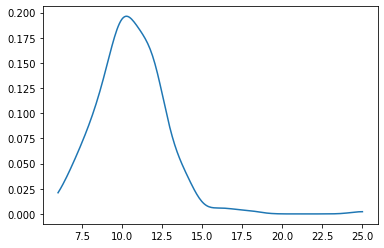

In [9]:
from scipy.stats import kde
import matplotlib.pyplot as plt     
density = kde.gaussian_kde(eyey) # x: list of price
xgrid = np.linspace(eyey.min(), eyey.max(), eyey.size)   
plt.plot(xgrid, density(xgrid))
plt.show()

In [10]:
##눈 세로 길이 10미만, 30이상 제거 eyes.shape[0]
##눈 가로 길이 18미만, 30이상 제거 eyes.shape[1]
  
pupil_len = np.array([])
pupil_std = np.array([])
for i in range(249):
    filename = 'C:/Users/ICT01_03/Documents/Personal_Color/face/face_'+str(i+1)
    im, landmarks = read_im_and_landmarks(filename+'.jpg')
    origin = im.copy()
    color_location = ((landmarks[54]+landmarks[11]+landmarks[45])/3).astype(int)
    rgb = im[color_location[0, 1], color_location[0, 0]][2],
    im[color_location[0, 1], color_location[0, 0]][1], im[color_location[0, 1], color_location[0, 0]][0]

    im_annotated = (im, landmarks)
    im_annotated = annotate_landmarks(im, landmarks)
    std, leng, eyes = eye_l_value(filename,landmarks)
    if(eyes.shape[0]>=10 & eyes.shape[0]<=30 & eyes.shape[1]>=18 & eyes.shape[1]<=30 & leng>10): # length 10이하 제거
        pupil_len = np.append(pupil_len, leng)
        pupil_std = np.append(pupil_std, std)
        print('-------'+str(i+1)+'번째 사진 길이: '+str(leng)+', 표준편차: '+str(std)+'-------')        


Medium
-------1번째 사진 길이: 89, 표준편차: 43.9857576426111-------
Dark
Medium
Dark
Dark
Light
Medium
Dark
-------8번째 사진 길이: 86, 표준편차: 32.551801708715054-------
Light
-------9번째 사진 길이: 157, 표준편차: 54.81763569779609-------
Light
-------10번째 사진 길이: 155, 표준편차: 53.69029932320357-------
Dark
Medium
-------12번째 사진 길이: 144, 표준편차: 44.855163326905114-------
Dark
-------13번째 사진 길이: 504, 표준편차: 31.333380574416392-------
Medium
Medium
-------15번째 사진 길이: 144, 표준편차: 42.17083804484233-------
Dark
-------16번째 사진 길이: 93, 표준편차: 35.233617367628-------
Dark
Dark
-------18번째 사진 길이: 127, 표준편차: 31.846812720254448-------
Dark
-------19번째 사진 길이: 122, 표준편차: 34.92807617434042-------
Light
Medium
Dark
-------22번째 사진 길이: 118, 표준편차: 28.13348981314548-------
Medium
Dark
-------24번째 사진 길이: 112, 표준편차: 32.13769303754565-------
Dark
Dark
-------26번째 사진 길이: 61, 표준편차: 34.66836781498545-------
Light
Dark
Dark
Dark
-------30번째 사진 길이: 121, 표준편차: 33.54153180128786-------
Dark
-------31번째 사진 길이: 89, 표준편차: 33.541939935392314-------
Mediu

In [12]:
# #################################################### KMeans 공부하기
# from sklearn.cluster import KMeans

# std_final = np.array([])
# for i in range(labels.size):
#     if labels[i]==0:
#         std_final = np.append(std_final,pupil_std[i])
        
# kmeans = KMeans(n_clusters=2)
# km_eln = kmeans.fit(np.reshape(std_final,(len(std_final),1)))
# centroids = kmeans.cluster_centers_

# labels = kmeans.labels_

# print(centroids)

# colors = ["g.","r."]

# for i in range(len(std_final)):
#     plt.plot(std_final[i], colors[labels[i]], markersize = 10)

# plt.scatter(centroids[:, 0], marker = "x", s = 150, linewidths = 5, zorder = 10)
# plt.show()

In [13]:
# #각 클러스터가 어떤 군집인지 보기 위한 것 
# clu0=np.array([])
# clu1=np.array([])
# labels = clustering.labels_
# for i,val in zip(labels,stds):
#     if i == 0:
#         clu0=np.append(clu0,val)
#     else:
#         clu1=np.append(clu1,val)
        
# print("Dark L*value min: "+str(clu0.min()))
# print("Dark L*value max: "+str(clu0.max()))
# print("Light L*value min: "+str(clu1.min()))
# print("Light L*value max: "+str(clu1.max()))
# print("Boundary : "+str((clu0.max()+clu1.min())/2))
# # 값이 작은 쪽이 분산이 작으므로 어두운 것, 큰 쪽이 밝은 것

# PCCS

In [14]:
import pandas as pd
import cufflinks as cf
cf.go_offline()

# PCCS 색 체계, 총 12 종류의 톤
# 봄웜톤은 △pale △light △bright △vivid 
# 여름쿨톤은 △pale △light △light grayish △soft △dull △bright 
# 가을웜톤은 △deep △strong △bright △dark 
# 겨울쿨톤은 △dark △dark grayish △deep △strong
# 아래 모두 RGB 컬러이며 여러 종류의 색깔이 다 있음
vivid = [['#b91f57', 185, 31, 87], ['#d02f48', 208, 47, 72], ['#dd443b', 221, 68, 59],
         ['#e95b23', 233, 91, 35], ['#e67800', 230, 120, 0], ['#f49d00', 244, 157, 0],
         ['#f1b500', 241, 181, 0], ['#eec900', 238, 201, 0], ['#d2c100', 210, 193, 0],
         ['#a8bb00', 168, 187, 0], ['#58a91d', 88, 169, 29], ['#00a15a', 0, 161, 90], 
         ['#00926e', 0, 146, 110], ['#00857f', 0, 133, 127], ['#007488', 0, 116, 136], 
         ['#00709b', 0, 112, 155], ['#00609c', 0, 96, 156], ['#005ba5', 0, 91, 165], 
         ['#1a54a5', 26, 84, 165], ['#534aa0', 83, 74, 160], ['#703f96', 112, 63, 150], 
         ['#81378a', 129, 55, 138], ['#8f2e7c', 143, 46, 124], ['#ad2e6c', 173, 46, 108]]

bright = [['#ef6c70', 239, 108, 112], ['#fa8155', 250, 129, 85], ['#ffad36', 255, 173, 54],
          ['#fad831', 250, 216, 49], ['#b7c82b', 183, 200, 43], ['#41b879', 65, 184, 121],
          ['#00aa9f', 0, 170, 159], ['#0098b9', 0, 152, 185], ['#2981c0', 41, 129, 192],
          ['#7574bc', 117, 116, 188], ['#a165a8', 161, 101, 168], ['#d0678e', 208, 103, 142]]

strong = [['#c53f4d', 197, 63, 77], ['#cc572e', 204, 87, 46], ['#e19215', 225, 146, 21],
          ['#debc03', 222, 188, 3], ['#9cad00', 156, 173, 0], ['#008f56', 0, 143, 86],
          ['#00827c', 0, 130, 124], ['#006f92', 0, 111, 146], ['#005b9b', 0, 91, 155],
          ['#534c98', 83, 76, 152], ['#7c3d84', 124, 61, 132], ['#a33c6a', 163, 60, 106]]
          
deep = [['#a61d39', 166, 29, 57], ['#ab3d1d', 171, 61, 29], ['#b16c00', 177, 108, 0],
        ['#b39300', 179, 147, 0], ['#748400', 116, 132, 0], ['#007243', 0, 114, 67], 
        ['#006664', 0, 102, 100], ['#005476', 0, 84, 118], ['#004280', 0, 66, 128],
        ['#3e337b', 62, 51, 123], ['#612469', 97, 36, 105], ['#861d55', 134, 29, 85]]

light = [['#f6aba5', 246, 171, 165], ['#ffb99e', 255, 185, 158], ['#ffce90', 255, 206, 144],
         ['#fbe68f', 251, 230, 143], ['#d8df92', 216, 223, 146], ['#9cd9ac', 156, 217, 172],
         ['#7eccc1', 126, 204, 193], ['#79baca', 121, 186, 202], ['#83a7c8', 131, 167, 200],
         ['#a29fc7', 162, 159, 199], ['#b89ab8', 184, 154, 184], ['#daa0b3', 218, 160, 179]]

soft = [['#ca8281', 202, 130, 129], ['#da927a', 218, 146, 122], ['#dba66b', 219, 166, 107],
        ['#d3bd6c', 211, 189, 108], ['#adb66b', 173, 182, 107], ['#76b18a', 118, 177, 138],
        ['#54a39b', 84, 163, 155], ['#5192a4', 81, 146, 164], ['#5d7ea0', 93, 126, 160],
        ['#7878a0', 120, 120, 160], ['#907194', 144, 113, 148], ['#b4788b', 180, 120, 139]]

dull = [['#a35a5c', 163, 90, 92], ['#af6954', 175, 105, 84], ['#b37f46', 79, 127, 70],
        ['#ab9446', 171, 148, 70], ['#858f46', 133, 143, 70], ['#4f8766', 79, 135, 102],
        ['#2a7b76', 42, 123, 118], ['#246a7d', 36, 106, 125], ['#34597d', 52, 89, 125],
        ['#54527c', 84, 82, 124], ['#6c4a71', 108, 74, 113], ['#8b4f65', 139, 79, 101]]

dark = [['#692934', 105, 41, 52], ['#75362a', 117, 54, 42], ['#794d1c', 121, 77, 28],
        ['#74601f', 116, 96, 31], ['#525b20', 82, 91, 32], ['#23523a', 35, 82, 58],
        ['#004746', 0, 71, 70], ['#004558', 0, 69, 88], ['#123452', 18, 52, 82],
        ['#322d51', 50, 45, 81], ['#432848', 67, 40, 72], ['#612d46', 97, 45, 70]]

pale = [['#e7d5d4', 231, 213, 212], ['#e9d5cf', 233, 213, 207], ['#f6e3ce', 246, 227, 206],
        ['#efe6c6', 239, 230, 198], ['#e6e9c6', 230, 233, 198], ['#c4e0cb', 196, 224, 203],
        ['#bfe0d9', 191, 224, 217], ['#c6dde2', 198, 221, 226], ['#c2ccd5', 194, 204, 213],
        ['#c9cad5', 201, 202, 213], ['#d0c8d1', 208, 200, 209], ['#e4d5d9', 228, 213, 217]]

grayish = [['#745c5c', 116, 92, 92], ['#755c57', 117, 92, 87], ['#806c5c', 128, 108, 92],
           ['#786f57', 120, 111, 87], ['#6e725a', 110, 114, 90], ['#53665a', 83, 102, 90],
           ['#4e6764', 78, 103, 100], ['#4f656c', 79, 101, 108], ['#4c5765', 76, 87, 101],
           ['#565566', 86, 85, 102], ['#605262', 96, 82, 98], ['#725c63', 114, 92, 9]]

dark_grayish = [['#3e2d30', 62, 45, 48], ['#3f2e2c', 63, 46, 44], ['#4a3c32', 74, 60, 50], 
                ['#443e30', 68, 62, 48], ['#3d4033', 61, 64, 51], ['#2a342e', 42, 52, 46], 
                ['#273434', 39, 52, 52], ['#273439', 39, 52, 57], ['#222933', 34, 41, 51], 
                ['#292734', 41, 39, 52], ['#302531', 48, 37, 49], ['#3d2e34', 61, 46, 52]]

light_grayish = [['#c0abaa', 192, 171, 170], ['#c1aba5', 193, 171, 165], 
                 ['#cebba8', 206, 187, 168], ['#c6bea1', 198, 190, 161], 
                 ['#bdc1a2', 189, 193, 162], ['#9db6a5', 157, 182, 165],
                 ['#98b6b1', 152, 182, 177], ['#9eb4b9', 158, 180, 185], 
                 ['#9ba5af', 155, 165, 175], ['#a2a2af', 162, 162, 175], 
                 ['#aba0ab', 171, 160, 171], ['#bdacb0', 189, 172, 176]]

pccs = ['vivid', 'bright', 'strong', 'deep', 'light', 'soft', 'dull', 'dark', 
        'pale', 'grayish', 'dark_grayish', 'light_grayish']

In [15]:
pccs_df = pd.DataFrame(columns = ['x','y','Type'])

# Calculate v and s and convert to (x,y)
# v; value(lightness), s; saturation
for color in pccs:
    var_color = globals()['{}'.format(color)]
    s = list(map(lambda x: (max(x[1:])-min(x[1:]))/max(x[1:]), var_color)) # 정규화
    v = list(map(lambda x: max(x[1:]), var_color)) # R/G/B 상관없이 최대값들의 평균
    x = sum(s)/len(s)
    y = sum(v)/len(v)
    pccs_df.loc[pccs_df.shape[0]] = [x,y,color]
    
pccs_df

,x,y,Type
0,0.874645,181.125000,vivid
1,0.692095,207.416667,bright
2,0.834804,170.166667,strong
3,0.890150,137.416667,deep
4,0.330006,221.166667,light
5,0.398006,182.000000,soft
6,0.500221,138.583333,dull
7,0.681574,93.583333,dark
8,0.110734,226.583333,pale
9,0.285509,110.250000,grayish


In [16]:
var_color = globals()['{}'.format('vivid')]
var_color

[['#b91f57', 185, 31, 87],
 ['#d02f48', 208, 47, 72],
 ['#dd443b', 221, 68, 59],
 ['#e95b23', 233, 91, 35],
 ['#e67800', 230, 120, 0],
 ['#f49d00', 244, 157, 0],
 ['#f1b500', 241, 181, 0],
 ['#eec900', 238, 201, 0],
 ['#d2c100', 210, 193, 0],
 ['#a8bb00', 168, 187, 0],
 ['#58a91d', 88, 169, 29],
 ['#00a15a', 0, 161, 90],
 ['#00926e', 0, 146, 110],
 ['#00857f', 0, 133, 127],
 ['#007488', 0, 116, 136],
 ['#00709b', 0, 112, 155],
 ['#00609c', 0, 96, 156],
 ['#005ba5', 0, 91, 165],
 ['#1a54a5', 26, 84, 165],
 ['#534aa0', 83, 74, 160],
 ['#703f96', 112, 63, 150],
 ['#81378a', 129, 55, 138],
 ['#8f2e7c', 143, 46, 124],
 ['#ad2e6c', 173, 46, 108]]

In [17]:
pccs_df.iplot(kind='scatter', mode='markers', x='x', y='y',text='Type', categories='Type')

C:\Users\ICT01_03\Anaconda3\envs\venv\lib\site-packages\cufflinks\plotlytools.py:808: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

C:\Users\ICT01_03\Anaconda3\envs\venv\lib\site-packages\cufflinks\plotlytools.py:811: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



# Ensemble for Personal-Color selection

In [18]:
# # RGB인가 BGR인가 LAB인가 LAB 8비트인가
# # 원본 데이터
# Warm=[[243, 129, 141],
#  [238, 131, 140],
#  [231, 134, 146],
#  [224, 136, 151],
#  [205, 139, 150],
#  [194, 138, 154],
#  [190, 141, 164],
#  [192, 141, 153],
#  [175, 145, 159],
#  [184, 137, 154],
#  [185, 142, 159]]

# Cool=[[231, 136, 142],
#  [228, 136, 146],
#  [217, 143, 149],
#  [214, 137, 141],
#  [193, 146, 148],
#  [184, 141, 148],
#  [182, 143, 150],
#  [183, 146, 149],
#  [118, 150, 164],
#  [127, 143, 157],
#  [112, 144, 157],
#  [92, 141, 148],
#  [64, 154, 154],
#  [57, 145, 138],
#  [53, 149, 141],
#  [51, 143, 134]]

In [83]:
# 원본 데이터 + 메이블린 + mk + 랑콤
Warm=[[243, 129, 141], [238, 131, 140], [231, 134, 146], [224, 136, 151], [205, 139, 150],
 [194, 138, 154], [190, 141, 164], [192, 141, 153], [175, 145, 159], [184, 137, 154],
 [185, 142, 159],[85,143,154],[88,143,155],[87,143,154],[107,142,156],[107,142,156],[107,142,156],[149,140,157],[149,140,157],[149,140,157],[154,135,152],[154,135,152],[154,135,152],[162,137,153],[162,137,153],[162,137,153],[172,138,154],[172,138,154],[174,138,155],[179,139,152],[183,138,153],[179,139,152],[183,135,148],[188,135,149],[183,135,148],[190,134,144],[190,134,144],[190,134,144],[193,134,144],[193,134,144],[193,134,144],[109,146,138],[123,145,145],[142,146,148],[149,145,148],[157,149,152],[169,141,149],[171,141,147],[176,146,149],[182,140,147],[196,141,152],[183,143,150],[179,145,146],[194,141,148],[194,140,151],[187,139,150],[188,140,148],[202,136,148],[209,134,148],[213,135,144],[220,133,143],[211,129,144],[224,136,140],[234,132,137],[81,147,152],[101,151,154],[129,150,158],[150,148,158],[148,146,166],[165,143,161],[170,144,164],[181,145,164],[181,148,159],[185,141,159],[193,138,155],[206,141,157],[211,138,156],[197,138,153],[199,137,155],[204,139,148]]

Cool=[[231, 136, 142], [228, 136, 146], [217, 143, 149], [214, 137, 141], [193, 146, 148],
 [184, 141, 148], [182, 143, 150], [183, 146, 149], [118, 150, 164], [127, 143, 157],
 [112, 144, 157], [92, 141, 148], [64, 154, 154], [57, 145, 138], [53, 149, 141],
 [51, 143, 134],[56,140,146],[56,139,146],[56,140,146],[73,142,153],[73,142,153],[73,142,153],[114,140,153],[114,140,153],[114,140,153],[158,138,152],[158,138,152],[158,138,152],[168,138,150],[182,138,145],[182,138,145],[182,138,145],[79,141,139],[93,145,140],[108,149,147],[121,148,150],[154,147,146],[158,150,152],[173,148,147],[170,146,151],[194,138,148],[186,144,144],[216,138,143],[207,138,143],[207,148,137],[205,135,143],[212,143,143],[220,136,143],[35,142,142],[86,153,150],[54,147,145],[83,152,162],[119,150,153],[146,149,157],[108,150,162],[164,148,161],[167,146,160],[180,144,153],[192,141,152],[194,137,150],[207,139,150]]

In [84]:
# 웜톤 컬러 
[n[1]/n[0]-n[2]/n[0] for n in Warm]

[-0.04938271604938271,
 -0.037815126050420145,
 -0.051948051948051965,
 -0.06696428571428581,
 -0.05365853658536579,
 -0.08247422680412364,
 -0.12105263157894741,
 -0.0625,
 -0.07999999999999996,
 -0.09239130434782616,
 -0.09189189189189184,
 -0.12941176470588234,
 -0.13636363636363646,
 -0.12643678160919536,
 -0.13084112149532712,
 -0.13084112149532712,
 -0.13084112149532712,
 -0.11409395973154357,
 -0.11409395973154357,
 -0.11409395973154357,
 -0.11038961038961037,
 -0.11038961038961037,
 -0.11038961038961037,
 -0.09876543209876543,
 -0.09876543209876543,
 -0.09876543209876543,
 -0.09302325581395354,
 -0.09302325581395354,
 -0.09770114942528729,
 -0.07262569832402233,
 -0.08196721311475419,
 -0.07262569832402233,
 -0.07103825136612019,
 -0.07446808510638292,
 -0.07103825136612019,
 -0.052631578947368474,
 -0.052631578947368474,
 -0.052631578947368474,
 -0.051813471502590636,
 -0.051813471502590636,
 -0.051813471502590636,
 0.07339449541284404,
 0.0,
 -0.014084507042253502,
 -0.020134

In [85]:
[n[1]/n[0]-n[2]/n[0] for n in Cool]

[-0.02597402597402587,
 -0.04385964912280704,
 -0.027649769585253448,
 -0.01869158878504673,
 -0.01036269430051806,
 -0.03804347826086962,
 -0.038461538461538436,
 -0.016393442622950838,
 -0.1186440677966103,
 -0.11023622047244097,
 -0.11607142857142838,
 -0.07608695652173925,
 0.0,
 0.12280701754385959,
 0.15094339622641506,
 0.17647058823529393,
 -0.1071428571428572,
 -0.125,
 -0.1071428571428572,
 -0.15068493150684925,
 -0.15068493150684925,
 -0.15068493150684925,
 -0.11403508771929816,
 -0.11403508771929816,
 -0.11403508771929816,
 -0.08860759493670889,
 -0.08860759493670889,
 -0.08860759493670889,
 -0.07142857142857151,
 -0.038461538461538436,
 -0.038461538461538436,
 -0.038461538461538436,
 0.025316455696202445,
 0.053763440860215006,
 0.01851851851851838,
 -0.016528925619834878,
 0.006493506493506551,
 -0.012658227848101333,
 0.005780346820809301,
 -0.02941176470588236,
 -0.05154639175257725,
 0.0,
 -0.02314814814814825,
 -0.024154589371980673,
 0.05314009661835739,
 -0.03902439

In [86]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

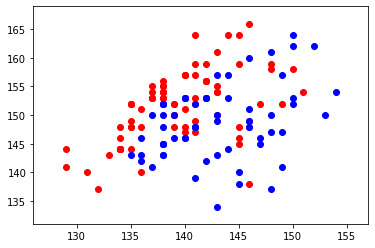

In [87]:
fig = plt.figure()
ax = fig.gca()
theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
#z = np.linspace(0, 300, 100)

x_min = min([n[1] for n in Warm]+[n[1] for n in Cool]) - 3
x_max = max([n[1] for n in Warm]+[n[1] for n in Cool]) + 3

y_min = min([n[2] for n in Warm]+[n[2] for n in Cool]) - 3
y_max = max([n[2] for n in Warm]+[n[2] for n in Cool]) + 3

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

ax.plot( [n[1] for n in Warm],[n[2] for n in Warm],'ro')
ax.plot( [n[1] for n in Cool],[n[2] for n in Cool],'bo')

# Red dots are Warm tone, Blue dots are Cool tone. X axis is A, Y axis is B.

In [137]:
Y=np.array([[n[0] for n in Warm]+[n[0] for n in Cool]])
Y = Y.T
Y.shape

(141, 1)

In [138]:
X1 = [ [n[1],n[2]] for n in Warm ]
X2 = [ [n[1],n[2]] for n in Cool ]
X = np.array(X1 + X2)
test_size = 0.5
seed = 2
# X.shape
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)

In [139]:
warm= [[n[1],n[2]] for n in Warm]
print(warm)

cool = [[n[1],n[2]] for n in Cool]
print(cool)

X = warm+cool

[[129, 141], [131, 140], [134, 146], [136, 151], [139, 150], [138, 154], [141, 164], [141, 153], [145, 159], [137, 154], [142, 159], [143, 154], [143, 155], [143, 154], [142, 156], [142, 156], [142, 156], [140, 157], [140, 157], [140, 157], [135, 152], [135, 152], [135, 152], [137, 153], [137, 153], [137, 153], [138, 154], [138, 154], [138, 155], [139, 152], [138, 153], [139, 152], [135, 148], [135, 149], [135, 148], [134, 144], [134, 144], [134, 144], [134, 144], [134, 144], [134, 144], [146, 138], [145, 145], [146, 148], [145, 148], [149, 152], [141, 149], [141, 147], [146, 149], [140, 147], [141, 152], [143, 150], [145, 146], [141, 148], [140, 151], [139, 150], [140, 148], [136, 148], [134, 148], [135, 144], [133, 143], [129, 144], [136, 140], [132, 137], [147, 152], [151, 154], [150, 158], [148, 158], [146, 166], [143, 161], [144, 164], [145, 164], [148, 159], [141, 159], [138, 155], [141, 157], [138, 156], [138, 153], [137, 155], [139, 148]]
[[136, 142], [136, 146], [143, 149], [1

In [141]:
# RGB인가 BGR인가 LAB인가 LAB 8비트인가

# 메이블린 웜톤 쿨톤 색상 참조
mabelline_warm = [[85,143,154],[88,143,155],[87,143,154],[107,142,156],[107,142,156],[107,142,156],[149,140,157],[149,140,157],[149,140,157],[154,135,152],[154,135,152],[154,135,152],[162,137,153],[162,137,153],[162,137,153],[172,138,154],[172,138,154],[174,138,155],[179,139,152],[183,138,153],[179,139,152],[183,135,148],[188,135,149],[183,135,148],[190,134,144],[190,134,144],[190,134,144],[193,134,144],[193,134,144],[193,134,144]]
mabelline_cool = [[56,140,146],[56,139,146],[56,140,146],[73,142,153],[73,142,153],[73,142,153],[114,140,153],[114,140,153],[114,140,153],[158,138,152],[158,138,152],[158,138,152],[168,138,150],[182,138,145],[182,138,145],[182,138,145]]

warm2= [[n[1],n[2]] for n in mabelline_warm]
print(warm2)
cool2 = [[n[1],n[2]] for n in mabelline_cool]
print(cool2)

# mk 쿨웜
mk_warm_tone2 = [[109,146,138],[123,145,145],[142,146,148],[149,145,148],[157,149,152],[169,141,149],[171,141,147],[176,146,149],[182,140,147],[196,141,152],[183,143,150],[179,145,146],[194,141,148],[194,140,151],[187,139,150],[188,140,148],[202,136,148],[209,134,148],[213,135,144],[220,133,143],[211,129,144],[224,136,140],[234,132,137]]
mk_cool_tone2 = [[79,141,139],[93,145,140],[108,149,147],[121,148,150],[154,147,146],[158,150,152],[173,148,147],[170,146,151],[194,138,148],[186,144,144],[216,138,143],[207,138,143],[207,148,137],[205,135,143],[212,143,143],[220,136,143]]

#warm4 = [[min(n[1]+128, 255),min(n[2]+128, 255)] for n in mk_warm_tone2]
#cool4 = [[min(n[1]+128, 255),min(n[2]+128, 255)] for n in mk_cool_tone2]


warm4= [[n[1],n[2]] for n in mk_warm_tone2]
print(warm4)

cool4 = [[n[1],n[2]] for n in mk_cool_tone2]
print(cool4)


# 랑콤 웜톤 쿨톤 색상 참조
lancome_cool=[[35,142,142],[86,153,150],[54,147,145],[83,152,162],[119,150,153],[146,149,157],[108,150,162],[164,148,161],[167,146,160],[180,144,153],[192,141,152],[194,137,150],[207,139,150]]
lancome_warm=[[81,147,152],[101,151,154],[129,150,158],[150,148,158],[148,146,166],[165,143,161],[170,144,164],[181,145,164],[181,148,159],[185,141,159],[193,138,155],[206,141,157],[211,138,156],[197,138,153],[199,137,155],[204,139,148]]

#warm5 = [[min(n[1]+128, 255),min(n[2]+128, 255)] for n in mk_warm_tone3]
#cool5 = [[min(n[1]+128, 255),min(n[2]+128, 255)] for n in mk_cool_tone3]

warm5= [[n[1],n[2]] for n in lancome_warm]
print(warm5)
cool5 = [[n[1],n[2]] for n in lancome_cool]
print(cool5)

# 에스티로더 웜톤 쿨톤 색상 참조



[[143, 154], [143, 155], [143, 154], [142, 156], [142, 156], [142, 156], [140, 157], [140, 157], [140, 157], [135, 152], [135, 152], [135, 152], [137, 153], [137, 153], [137, 153], [138, 154], [138, 154], [138, 155], [139, 152], [138, 153], [139, 152], [135, 148], [135, 149], [135, 148], [134, 144], [134, 144], [134, 144], [134, 144], [134, 144], [134, 144]]
[[140, 146], [139, 146], [140, 146], [142, 153], [142, 153], [142, 153], [140, 153], [140, 153], [140, 153], [138, 152], [138, 152], [138, 152], [138, 150], [138, 145], [138, 145], [138, 145]]
[[146, 138], [145, 145], [146, 148], [145, 148], [149, 152], [141, 149], [141, 147], [146, 149], [140, 147], [141, 152], [143, 150], [145, 146], [141, 148], [140, 151], [139, 150], [140, 148], [136, 148], [134, 148], [135, 144], [133, 143], [129, 144], [136, 140], [132, 137]]
[[141, 139], [145, 140], [149, 147], [148, 150], [147, 146], [150, 152], [148, 147], [146, 151], [138, 148], [144, 144], [138, 143], [138, 143], [148, 137], [135, 143], 

In [142]:
# RGB 컬러값 -> LAB 컬러값 변환
# !pip install colormath 
from colormath.color_objects import LabColor, sRGBColor 
from colormath.color_conversions import convert_color
import numpy as np

# RGB 컬러값을 LAB 컬러값으로 바꾸는 함수
def rgb2lab ( inputColor ) :

   num = 0
   RGB = [0, 0, 0]

   for value in inputColor :
       value = float(value) / 255

       if value > 0.04045 :
           value = ( ( value + 0.055 ) / 1.055 ) ** 2.4
       else :
           value = value / 12.92

       RGB[num] = value * 100
       num = num + 1

   XYZ = [0, 0, 0,]

   X = RGB [0] * 0.4124 + RGB [1] * 0.3576 + RGB [2] * 0.1805
   Y = RGB [0] * 0.2126 + RGB [1] * 0.7152 + RGB [2] * 0.0722
   Z = RGB [0] * 0.0193 + RGB [1] * 0.1192 + RGB [2] * 0.9505
   XYZ[ 0 ] = round( X, 4 )
   XYZ[ 1 ] = round( Y, 4 )
   XYZ[ 2 ] = round( Z, 4 )

   XYZ[ 0 ] = float( XYZ[ 0 ] ) / 95.047         # ref_X =  95.047   Observer= 2°, Illuminant= D65
   XYZ[ 1 ] = float( XYZ[ 1 ] ) / 100.0          # ref_Y = 100.000
   XYZ[ 2 ] = float( XYZ[ 2 ] ) / 108.883        # ref_Z = 108.883

   num = 0
   for value in XYZ :

       if value > 0.008856 :
           value = value ** ( 0.3333333333333333 )
       else :
           value = ( 7.787 * value ) + ( 16 / 116 )

       XYZ[num] = value
       num = num + 1

   Lab = [0, 0, 0]

   L = ( 116 * XYZ[ 1 ] ) - 16
   a = 500 * ( XYZ[ 0 ] - XYZ[ 1 ] )
   b = 200 * ( XYZ[ 1 ] - XYZ[ 2 ] )

   Lab [ 0 ] = round( L, 4 )
   Lab [ 1 ] = round( a, 4 )
   Lab [ 2 ] = round( b, 4 )

   return Lab

# RGB가 담긴 넘파이 array를 통째로 LAB으로 바꾸기 - np.array() 씌우기
def npRGB2LAB(nparray):
    newarray = []
    for i in range(len(nparray)):
        newarray.append(rgb2lab((nparray[i,0], nparray[i,1], nparray[i,2])))
    print(np.around(newarray))

# RGB값이 담긴 리스트를 통째로 LAB값으로 바꾸기 - np.array() 씌우기
def listRGB2LAB(RGBlist):
    newlist = []
    for i in range(len(RGBlist)):
        newlist.append(rgb2lab([RGBlist[i,0], RGBlist[i,1], RGBlist[i,2]]))
    return np.round(newlist,0)

# RGB, LAB 컬러 체크: http://colorizer.org/

In [143]:
X2 = warm2+cool2
Y = [0 for n in Warm] + [1 for n in Cool ]
Y2 = [0 for n in warm2] + [1 for n in cool2 ]

In [144]:
# import numpy as np
# import matplotlib.pyplot as plt

# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.ensemble import GradientBoostingClassifier
# from itertools import product
# from sklearn.ensemble import VotingClassifier
# from sklearn.linear_model import SGDClassifier
# from sklearn.naive_bayes import GaussianNB
# #data = np.loadtxt("data.txt", delimiter=',')
# #dim = warm.shape

# #Warm = warm+warm2+warm4+warm5
# #Cool = cool+cool2+cool4+warm5

# Warm = warm+warm2+warm5
# Cool = cool+cool2+cool5
# x_min = min([n[0] for n in Warm]+[n[0] for n in Cool]) - 3
# x_max = max([n[0] for n in Warm]+[n[0] for n in Cool]) + 3
# y_min = min([n[1] for n in Warm]+[n[1] for n in Cool]) - 3
# y_max = max([n[1] for n in Warm]+[n[1] for n in Cool]) + 3

# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)


# plt.plot( [n[0] for n in warm],[n[1] for n in warm],'ro')
# plt.plot( [n[0] for n in cool],[n[1] for n in cool],'bo')

# plt.plot( [n[0] for n in warm5],[n[1] for n in warm5],'ro', marker='s')
# plt.plot( [n[0] for n in cool5],[n[1] for n in cool5],'bo', marker='s')

# #plt.plot( [n[0] for n in warm3],[n[1] for n in warm3],'ro', marker='*')
# #plt.plot( [n[0] for n in cool3],[n[1] for n in cool3],'bo', marker='*')

# plt.plot( [n[0] for n in warm2],[n[1] for n in warm2],'ro', marker='*')
# plt.plot( [n[0] for n in cool2],[n[1] for n in cool2],'bo', marker='*')


# X = Warm+ Cool
# Y = [0 for n in Warm] + [1 for n in Cool]

# y = Y

# bdt1 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
# bdt2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200)
# bdt3 = KNeighborsClassifier(n_neighbors=3)
# bdt4 = KNeighborsClassifier(n_neighbors=9)
# bdt5 = SVC(kernel='poly', probability=True)
# bdt6 = GaussianNB()
# bdt7 = KNeighborsClassifier(n_neighbors=5)


# eclf = VotingClassifier(estimators=[('gbc', bdt1),('ada', bdt2),('dtc', bdt3),('knn', bdt4),('svc', bdt5),('gnb', bdt6),('knn3', bdt7)], voting='soft', \
#                         weights=[0.01,0.01,0.5,2,0.5,2,0.5])
# bdt = eclf

# bdt1 = bdt1.fit(X,Y)
# bdt2 = bdt2.fit(X,Y)
# bdt3 = bdt3.fit(X,Y)
# bdt4 = bdt4.fit(X,Y)
# bdt5 = bdt5.fit(X,Y)
# bdt6 = bdt6.fit(X,Y)
# bdt7 = bdt7.fit(X,Y)

# #clf1 = clf1.fit(X,y)
# #clf2 = clf2.fit(X,y)
# #clf3 = clf3.fit(X,y)
# #bdt = eclf.fit(X,y)

# #bdt = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
# #bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200)
# #bdt = DecisionTreeClassifier(max_depth=4)
# #bdt = KNeighborsClassifier(n_neighbors=7)
# #bdt = SVC(kernel='rbf', probability=True)
# #bdt = SGDClassifier(loss="hinge", penalty="l2")#
# #bdt = KNeighborsClassifier()
# #bdt = GaussianNB()
# bdt = bdt.fit(X, Y)

# # ploting parameters setting
# plot_colors = "rb"
# plot_step = 0.2
# class_names = "AB"

# # plot the decision boundary
# #x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
# #y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
# #x_min = y_min = 100
# #x_max = y_max = 250

# xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),np.arange(y_min, y_max, plot_step))
# Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
# print(Z)

# Z = Z.reshape(xx.shape)
# cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

# # plot the training points
# #for i, n, c in zip(range(2), class_names, plot_colors):
#     #idx = np.where(Y == i)
# #    plt.scatter(X[idx, 0], X[idx, 1], c=c, cmap=plt.cm.Paired, label="Class %s" % n)

# plt.legend(loc='upper right')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Decision Boundary')

# plt.show()

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from itertools import product
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB

Warm = warm +warm2+warm5
Cool = cool+cool2+cool5
x_min = min([n[0] for n in Warm]+[n[0] for n in Cool]) - 3
x_max = max([n[0] for n in Warm]+[n[0] for n in Cool]) + 3
y_min = min([n[1] for n in Warm]+[n[1] for n in Cool]) - 3
y_max = max([n[1] for n in Warm]+[n[1] for n in Cool]) + 3

#plt.xlim(x_min, x_max)
#plt.ylim(y_min, y_max)
#plt.plot( [n[0] for n in warm],[n[1] for n in warm],'ro')
#plt.plot( [n[0] for n in cool],[n[1] for n in cool],'bo')
#plt.show()
#plt.plot( [n[0] for n in warm5],[n[1] for n in warm5],'ro', marker='s')
#plt.plot( [n[0] for n in cool5],[n[1] for n in cool5],'bo', marker='s')
#plt.show()
#plt.plot( [n[0] for n in warm2],[n[1] for n in warm2],'ro', marker='*')
#plt.plot( [n[0] for n in cool2],[n[1] for n in cool2],'bo', marker='*')
#plt.show()
X = Warm+ Cool
Y = [0 for n in Warm] + [1 for n in Cool]
# y = Y
bdt1 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=0)
bdt2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200)
bdt3 = KNeighborsClassifier(n_neighbors=3)
bdt4 = KNeighborsClassifier(n_neighbors=9)
bdt5 = SVC(kernel='poly', probability=True)
bdt6 = GaussianNB()
bdt7 = KNeighborsClassifier(n_neighbors=5)


#앙상블 
#다수결방법: soft voting: 가중치 투표, 개별 모형의 조건부 확롤의 합 기준
#estimators 개별 모형 목록
#voting  default=hard
#weights 사용자 가중치 리스트

ensemble = VotingClassifier(estimators=[('gbc', bdt1),('ada', bdt2),('dtc', bdt3),('knn', bdt4),('svc', bdt5),('gnb', bdt6),('knn3', bdt7)], voting='soft', \
                        weights=[0.01,0.01,0.5,2,0.5,2,0.5]) 
#('gnb', bdt6),
model = ensemble
bdt1 = bdt1.fit(X,Y)
bdt2 = bdt2.fit(X,Y)
bdt3 = bdt3.fit(X,Y)
bdt4 = bdt4.fit(X,Y)
bdt5 = bdt5.fit(X,Y)
bdt6 = bdt6.fit(X,Y)
bdt7 = bdt7.fit(X,Y)

#train_input=X.train_output=Y

model = model.fit(X, Y)

# predictions=ensemble.predict(X)

filename='classifier.sav'
pickle.dump(model,open(filename,'wb'))

loaded_model=pickle.load(open(filename,'rb'))
result=loaded_model.score(X,Y)
print(result)

0.8657407407407407


In [331]:
filename='classifier2.sav'
pickle.dump(model,open(filename,'wb'))

loaded_model=pickle.load(open(filename,'rb'))
result=loaded_model.score(X,Y)
print(result)

0.8657407407407407


In [146]:
predictions=ensemble.predict(X)
predictions

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0])

In [147]:
#ploting parameters setting
plot_colors = "rb"
plot_step = 0.2
class_names = "AB"

def tttt(n):
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),np.arange(y_min, y_max, plot_step))
    bdt_ = eval('bdt'+str(n))
    Z = bdt_.predict(np.c_[xx.ravel(), yy.ravel()])
    print(Z)
    plt.plot( [n[0] for n in warm],[n[1] for n in warm],'ro')
    plt.plot( [n[0] for n in cool],[n[1] for n in cool],'bo')

    plt.plot( [n[0] for n in warm2],[n[1] for n in warm2],'ro', marker='s')
    plt.plot( [n[0] for n in cool2],[n[1] for n in cool2],'bo', marker='s')
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    # plot the training points
    #for i, n, c in zip(range(2), class_names, plot_colors):
        #idx = np.where(Y == i)
    #    plt.scatter(X[idx, 0], X[idx, 1], c=c, cmap=plt.cm.Paired, label="Class %s" % n)

    plt.legend(loc='upper right')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Decision Boundary')
    plt.show()

No handles with labels found to put in legend.


[0 0 0 ... 1 1 1]


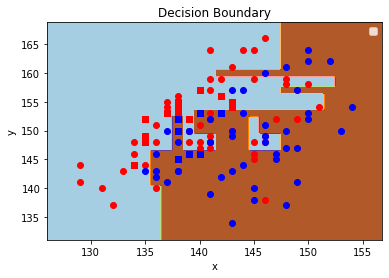

No handles with labels found to put in legend.


[0 0 0 ... 1 1 1]


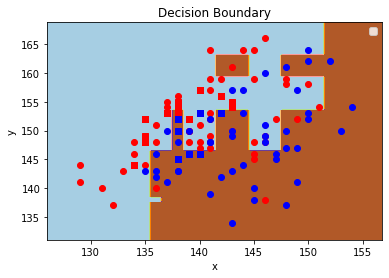

No handles with labels found to put in legend.


[0 0 0 ... 1 1 1]


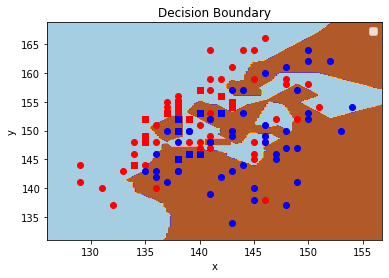

No handles with labels found to put in legend.


[0 0 0 ... 1 1 1]


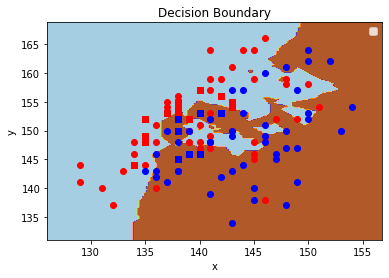

No handles with labels found to put in legend.


[0 0 0 ... 1 1 1]


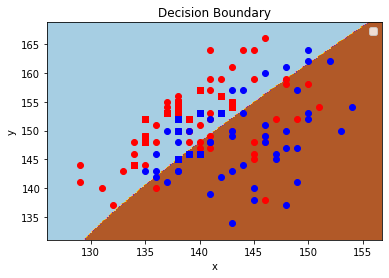

No handles with labels found to put in legend.


[0 0 0 ... 1 1 1]


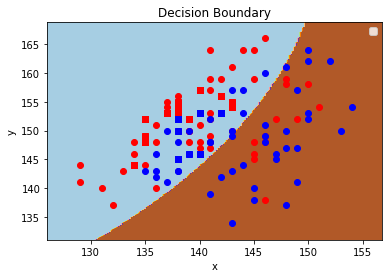

No handles with labels found to put in legend.


[0 0 0 ... 1 1 1]


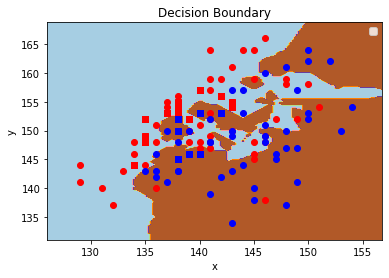

In [148]:
for i in range(1,8):
    tttt(i)

# Main

## Grayworld

In [333]:
from __future__ import division, absolute_import, print_function, unicode_literals
import cv2
import numpy as np
from skimage import io

def white_balance_loops(img): :, 1])
    avg_b = np.average(result[:, :,
    result = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    avg_a = np.average(result[:, 2])
    for x in range(result.shape[0]):
        for y in range(result.shape[1]):
            l, a, b = result[x, y, :]
            # fix for CV correction
            l *= 100 / 255.0
            result[x, y, 1] = a - ((avg_a - 128) * (l / 100.0) * 1.1)
            result[x, y, 2] = b - ((avg_b - 128) * (l / 100.0) * 1.1)
    result = cv2.cvtColor(result, cv2.COLOR_LAB2BGR)
    return result

SyntaxError: invalid syntax (<ipython-input-333-d4789f770532>, line 6)

In [334]:
### white balance
from skimage import io
from matplotlib import pyplot as plt
import scipy.ndimage
import sys

def apply_mask(matrix, mask, fill_value):
    masked = np.ma.array(matrix, mask=mask, fill_value=fill_value)
    return masked.filled()

def apply_threshold(matrix, low_value, high_value):
    low_mask = matrix < low_value
    matrix = apply_mask(matrix, low_mask, low_value)

    high_mask = matrix > high_value
    matrix = apply_mask(matrix, high_mask, high_value)

    return matrix

def simplest_cb(img, percent=1):
    assert img.shape[2] == 3
    assert percent > 0 and percent < 100

    half_percent = percent / 200.0

    channels = cv2.split(img)

    out_channels = []
    for channel in channels:
        assert len(channel.shape) == 2
        # find the low and high precentile values (based on the input percentile)
        height, width = channel.shape
        vec_size = width * height
        flat = channel.reshape(vec_size)

        assert len(flat.shape) == 1

        flat = np.sort(flat)

        n_cols = flat.shape[0]

        low_val  = flat[math.floor(n_cols * half_percent)]
        high_val = flat[math.ceil( n_cols * (1.0 - half_percent))]

        # saturate below the low percentile and above the high percentile
        thresholded = apply_threshold(channel, low_val, high_val)
        # scale the channel
        normalized = cv2.normalize(thresholded, thresholded.copy(), 0, 255, cv2.NORM_MINMAX)
        out_channels.append(normalized)

    return cv2.merge(out_channels)

## Landmark detection & Target Finding

In [335]:
# 얼굴 이미지 파일에 랜드마크 박고 저장하기

# 사용할 이미지 파일 불러들이기
path = 'C:/Users/ICT01_03/Documents/Personal_Color/face/'
filename = "pby"
img_type = "jpg" ## jpg or png etc...

# 랜드마크 박고 저장하기
im, landmarks = read_im_and_landmarks(path + filename+"."+img_type)
im_annotated = annotate_landmarks(im, landmarks)
cv2.imwrite(path + 'landmark/'+filename+'_landmarks.jpg', im_annotated) 

# 랜드마크
color_location1 = ((landmarks[54]+landmarks[11]+landmarks[45])/3).astype(int) # left cheek
color_location2 = ((landmarks[48]+landmarks[4]+landmarks[36])/3).astype(int) # right cheek

# 뺨 색을 뽑을 타겟 포인트를 사진에 찍고 저장하기
# rgb1=(206.5, 156.5, 132.5) : 세 개의 RGB 컬러값이 나옴. B, G, R 순서
rgb1 = im[color_location1[0, 1], color_location1[0, 0]][2], im[color_location1[0, 1], color_location1[0, 0]][1], im[color_location1[0, 1], color_location1[0, 0]][0]
rgb2 = im[color_location2[0, 1], color_location2[0, 0]][2], im[color_location2[0, 1], color_location2[0, 0]][1], im[color_location2[0, 1], color_location2[0, 0]][0]

rgb = ((int(rgb1[0])+int(rgb2[0]))/2, (int(rgb1[1])+int(rgb2[1]))/2, (int(rgb1[2])+int(rgb2[2]))/2)

cv2.putText(im, str("Target1"), (color_location1[0, 0]+5, color_location1[0, 1]),
                    fontFace=cv2.FONT_HERSHEY_TRIPLEX,
                    fontScale=0.5,
                    color=(0, 0, 255))
cv2.circle(im, (color_location1[0, 0], color_location1[0, 1]), 3, color=(0, 0, 255), thickness = -1)

cv2.putText(im, str("Target2"), (color_location2[0, 0]+5, color_location2[0, 1]),
                    fontFace=cv2.FONT_HERSHEY_TRIPLEX,
                    fontScale=0.5,
                    color=(0, 0, 255))
cv2.circle(im, (color_location2[0, 0], color_location2[0, 1]), 3, color=(0, 0, 255), thickness = -1)

im_annotated = annotate_landmarks(im, landmarks) # 랜드마크 번호 달기

cv2.imwrite(path + 'landmark/'+filename+'_target.jpg', im_annotated)


True

## a* b* value comparison

In [336]:
im = cv2.imread(path+filename+"."+img_type)
lab_colors = cv2.cvtColor(im, cv2.COLOR_BGR2LAB)
lab_colors

array([[[147, 132, 117],
        [151, 134, 116],
        [159, 132, 117],
        ...,
        [168, 133, 116],
        [168, 135, 114],
        [167, 137, 115]],

       [[146, 131, 121],
        [158, 130, 117],
        [160, 129, 118],
        ...,
        [166, 137, 115],
        [166, 136, 116],
        [167, 135, 115]],

       [[150, 128, 121],
        [161, 130, 117],
        [165, 132, 117],
        ...,
        [168, 136, 114],
        [168, 135, 115],
        [169, 134, 117]],

       ...,

       [[203, 140, 139],
        [201, 138, 143],
        [200, 139, 142],
        ...,
        [ 16, 138, 118],
        [ 24, 131, 121],
        [ 27, 137, 117]],

       [[201, 140, 141],
        [201, 138, 144],
        [202, 138, 143],
        ...,
        [ 18, 134, 120],
        [ 24, 136, 119],
        [ 25, 139, 119]],

       [[202, 138, 143],
        [199, 140, 140],
        [199, 139, 142],
        ...,
        [ 19, 137, 120],
        [ 25, 134, 116],
        [ 21, 135, 119]]

In [337]:
bgr_colors = cv2.cvtColor(im, cv2.COLOR_LAB2BGR)
bgr_colors

array([[[135, 143, 170],
        [132, 148, 186],
        [126, 146, 209],
        ...,
        [118, 152, 242],
        [120, 155, 243],
        [110, 155, 239]],

       [[126, 136, 162],
        [132, 146, 206],
        [133, 145, 213],
        ...,
        [109, 154, 236],
        [107, 152, 234],
        [114, 154, 240]],

       [[132, 137, 175],
        [130, 146, 215],
        [122, 148, 227],
        ...,
        [116, 156, 242],
        [113, 154, 242],
        [112, 151, 242]],

       ...,

       [[  0, 115, 255],
        [  0, 106, 255],
        [  0, 109, 255],
        ...,
        [189,  71,   0],
        [191,  71,   0],
        [188,  75,   0]],

       [[  0, 111, 255],
        [  0, 103, 255],
        [  0, 106, 255],
        ...,
        [191,  70,   0],
        [185,  72,   0],
        [181,  72,   0]],

       [[  0, 106, 255],
        [  0, 113, 255],
        [  0, 108, 255],
        ...,
        [181,  69,   0],
        [197,  76,   0],
        [186,  71,   0]]

In [338]:
(B,G,R) = cv2.split(im)
B, G, R

(array([[157, 164, 169, ..., 182, 184, 182],
        [150, 168, 170, ..., 181, 179, 182],
        [154, 171, 175, ..., 184, 183, 181],
        ...,
        [178, 168, 169, ...,  33,  35,  44],
        [172, 166, 169, ...,  32,  38,  39],
        [169, 172, 167, ...,  33,  43,  36]], dtype=uint8),
 array([[137, 140, 149, ..., 158, 157, 155],
        [136, 149, 152, ..., 154, 154, 156],
        [142, 152, 155, ..., 156, 157, 158],
        ...,
        [189, 187, 186, ...,  16,  25,  26],
        [187, 188, 188, ...,  21,  23,  23],
        [188, 185, 185, ...,  19,  24,  21]], dtype=uint8),
 array([[136, 142, 148, ..., 160, 160, 164],
        [137, 144, 145, ..., 164, 164, 162],
        [136, 147, 154, ..., 162, 163, 163],
        ...,
        [227, 224, 225, ...,  25,  25,  33],
        [226, 224, 225, ...,  23,  31,  34],
        [225, 223, 222, ...,  30,  27,  29]], dtype=uint8))

In [339]:
# color_location: 사진에서 x,y 좌표값
a_value1 = lab_colors[color_location1[0, 1], color_location1[0, 0]][1]
a_value2 = lab_colors[color_location2[0, 1], color_location2[0, 0]][1]
a_value = (int(a_value1) + int(a_value2))/2

b_value1 = lab_colors[color_location1[0, 1], color_location1[0, 0]][2]
b_value2 = lab_colors[color_location2[0, 1], color_location2[0, 0]][2]
b_value = (int(b_value1) + int(b_value2))/2

In [340]:
print(lab_colors[color_location1[0, 1], color_location1[0, 0]][0])
print(lab_colors[color_location1[0, 1], color_location1[0, 0]][1])
print(lab_colors[color_location1[0, 1], color_location1[0, 0]])
lab_colors[192]

180
141
[180 141 142]


array([[104, 134, 124],
       [129, 131, 121],
       [153, 133, 117],
       ...,
       [175, 135, 117],
       [174, 135, 117],
       [175, 135, 117]], dtype=uint8)

In [341]:
# 될지 모르겠다. 데이터프레임 만들어서 sav 파일 생성하기
# https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
import pandas as pd
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import pickle

names = ['cheek', 'eye', 'class']
df = pd.DataFrame(data={'cheek': [], 'eye': [], 'class':[]})
df

,cheek,eye,class


In [342]:
from sklearn.externals import joblib
loaded_model = joblib.load('classifier2.sav')
skin_ab_value = []

info = []
info.append(a_value)
info.append(b_value)

skin_ab_value.append(info)

def warm_or_cool(skin_ab_value):
    value = loaded_model.predict(skin_ab_value)
    
    if value == 0:
        return "warm"
    else:
        return "cool"

skin_ab_value

# import matplotlib.pyplot as plt

# plt.xlim(120, 160)
# plt.ylim(120, 170)

[[140.0, 142.0]]

## Extracting Eye Area

In [343]:
def cut_eyes(im,landmarks):
    im = im[landmarks[37][0, 1]+1:landmarks[40][0, 1]+1, landmarks[37][0, 0]-2:landmarks[38][0, 0]+3, :] 
    return im

cut_eyes = cut_eyes(im, landmarks)
cv2.imwrite(path+'eye/'+filename+'_eye.jpg', cut_eyes)

True

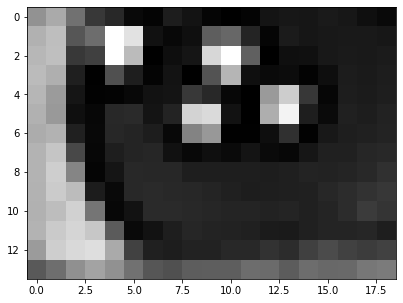

In [344]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
gray = cv2.cvtColor(cut_eyes, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 5))
plt.imshow(gray, cmap='gray')

## Pupil & Light (on Eye) Detection

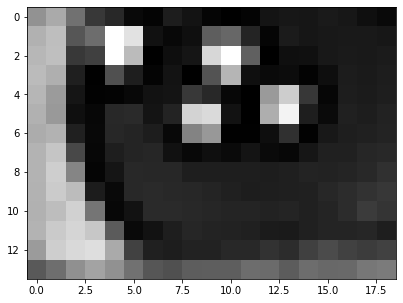

In [345]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
gray = cv2.cvtColor(cut_eyes, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 5))
plt.imshow(gray, cmap='gray')

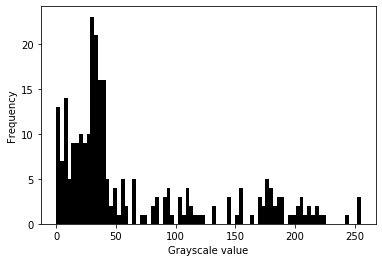

In [346]:
import numpy as np
import matplotlib.pyplot as plt

gray_resized = np.resize(gray, [gray.shape[0]*gray.shape[1]])
n, bins, patches = plt.hist(gray_resized, bins=80, color='black')

plt.xlabel("Grayscale value")
plt.ylabel("Frequency")
plt.show()

### Assuming Dark Eyes

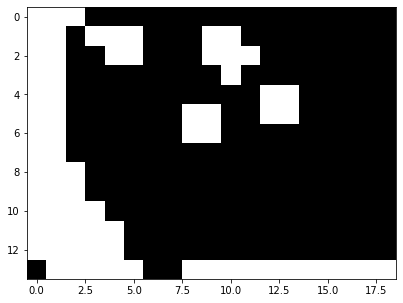

In [347]:
#Light on eye Detection (thresh = 90)
etval, thresholded = cv2.threshold(gray, 90, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 5))
plt.imshow(thresholded, cmap='gray')

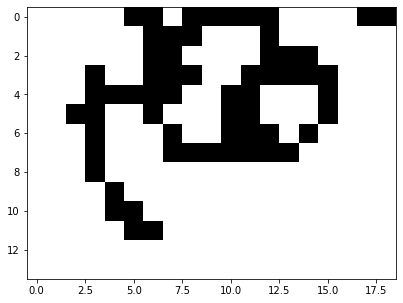

In [348]:
index_dark = []
i = 0

while i < cut_eyes.shape[0]:
    j = 0
    index_of_black = []
    while j < cut_eyes.shape[1]:
        if thresholded[i][j] == 0:
            index_of_black.append(i)
            index_of_black.append(j)
            index_dark.append(index_of_black)
            index_of_black = []
        j += 1
    i += 1
    
# Pupil Detection (thresh = 20)
etval, thresholded = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 5))
plt.imshow(thresholded, cmap='gray')

In [349]:
i = 0

while i < cut_eyes.shape[0]:
    j = 0
    index_deleted = []
    while j < cut_eyes.shape[1]:
        if thresholded[i][j] == 0:
            index_deleted.append(i)
            index_deleted.append(j)
            if index_deleted in index_dark:
                index_dark.remove(index_deleted)
            index_deleted = []
        j += 1
    i += 1

### Assuming Medium Brightness Eyes

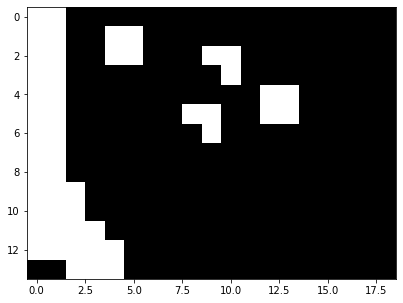

In [350]:
#Light on eye Detection (thresh = 140)

etval, thresholded = cv2.threshold(gray, 140, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 5))
plt.imshow(thresholded, cmap='gray')

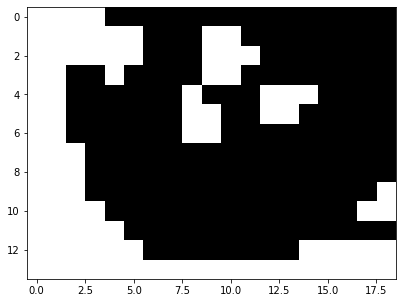

In [351]:
index_medium = []

i = 0

while i < cut_eyes.shape[0]:
    j = 0
    index_of_black = []
    while j < cut_eyes.shape[1]:
        if thresholded[i][j] == 0:
            index_of_black.append(i)
            index_of_black.append(j)
            index_medium.append(index_of_black)
            index_of_black = []
        j += 1
    i += 1
    
# Pupil Detection (thresh = 50)
etval, thresholded = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 5))
plt.imshow(thresholded, cmap='gray')

In [352]:
i = 0

while i < cut_eyes.shape[0]:
    j = 0
    index_deleted = []
    while j < cut_eyes.shape[1]:
        if thresholded[i][j] == 0:
            index_deleted.append(i)
            index_deleted.append(j)
            if index_deleted in index_medium:
                index_medium.remove(index_deleted)
            index_deleted = []
        j += 1
    i += 1

### Assuming Light Eyes

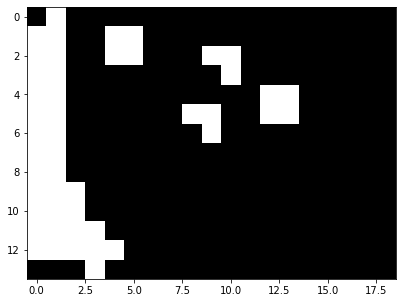

In [353]:
#Light on eye Detection (thresh = 140)

etval, thresholded = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 5))
plt.imshow(thresholded, cmap='gray')

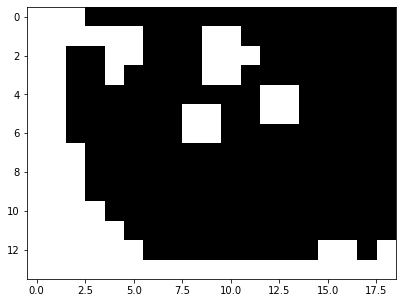

In [354]:
index_light = []
i = 0

while i < cut_eyes.shape[0]:
    j = 0
    index_of_black = []
    while j < cut_eyes.shape[1]:
        if thresholded[i][j] == 0:
            index_of_black.append(i)
            index_of_black.append(j)
            index_light.append(index_of_black)
            index_of_black = []
        j += 1
    i += 1
    
# Pupil Detection (thresh = 50)
etval, thresholded = cv2.threshold(gray, 65, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 5))
plt.imshow(thresholded, cmap='gray')

In [355]:
i = 0

while i < cut_eyes.shape[0]:
    j = 0
    index_deleted = []
    while j < cut_eyes.shape[1]:
        if thresholded[i][j] == 0:
            index_deleted.append(i)
            index_deleted.append(j)
            if index_deleted in index_light:
                index_light.remove(index_deleted)
            index_deleted = []
        j += 1
    i += 1

### Selecting which index to use

In [356]:
print("Length of index_dark : " + str(len(index_dark)))
print("Length of index_medium : " + str(len(index_medium)))
print("Length of index_light : " + str(len(index_light)))

Length of index_dark : 133
Length of index_medium : 43
Length of index_light : 36


In [357]:
def select_index_to_use():
    max = 0
    name_of_index = ""
    index_to_use = []
    
    if len(index_dark) > len(index_medium):
        max = len(index_dark)
        index_to_use = index_dark
        name_of_index = "index_dark"
    else:
        max = len(index_medium)
        index_to_use = index_medium
        name_of_index = "index_medium"
        
    
    if max < len(index_light):
        print("index_light")
        index_to_use = index_light
    else:
        print(name_of_index)
        
    return index_to_use

index_to_use = select_index_to_use()

index_dark


## L*value of Eye (15% is 0)

In [358]:
eye_lab = cv2.cvtColor(cut_eyes, cv2.COLOR_RGB2LAB)
eye_l_value = []

i = 0
while i < len(index_to_use):
    eye_l_value.append(eye_lab[index_to_use[i][0], index_to_use[i][1], 0])
    i += 1
    
i = 0
while i < int(len(eye_l_value)*15/85):
    eye_l_value.append(0)
    i += 1

    
def warm_or_cool(skin_ab_value):
    value = loaded_model.predict(skin_ab_value)
    
    if value == 0:
        return "warm"
    else:
        return "cool"
    

print("You are \"" + warm_or_cool(skin_ab_value) + "\" tone.")

You are "cool" tone.


In [359]:
eye_l_value = np.array(eye_l_value)
std = math.sqrt(np.sum((eye_l_value - np.mean(eye_l_value))**2)/(eye_l_value.size))

eye_brightness = ""

if std < 38.28:
    eye_brightness = "dark"
else:
    eye_brightness = "light"
    
def season_matching(skin_tone, eye_brightness):
    if skin_tone == "warm":
        if eye_brightness == "dark":
            return "autumn"
        else:
            return "spring"
    else:
        if eye_brightness == "dark":
            return "winter"
        else:
            return "summer"
season = season_matching(warm_or_cool(skin_ab_value), eye_brightness)

## Deep? Mute? Light? Bright?

In [360]:
color_info = [[0.87464539937997 * 255, 181, 'vivid'],
 [0.6920954876849125 * 255, 207, 'bright'],
 [0.8348038859274655 * 255, 170, 'strong'],
 [0.8901501134915047 * 255, 137, 'deep'],
 [0.3300064593086124 * 255, 221, 'light'],
 [0.39800595815638706 * 255, 182, 'soft'], 
 [0.5135643825656158 * 255, 142, 'dull'],
 [0.6815737217178439 * 255, 93, 'dark'],
 [0.11073418459625402 * 255, 226, 'pale'],
 [0.22483614835441365 * 255, 110, 'grayish'],
 [0.26913149326755986 * 255, 58, 'dark_grayish'],
 [0.20022609113608203 * 255, 186, 'light_grayish']]

spring_list = []
spring_list.append(color_info[0])
spring_list.append(color_info[1])
spring_list.append(color_info[4])
spring_list.append(color_info[8])
summer_list = []
summer_list.append(color_info[4])
summer_list.append(color_info[8])
summer_list.append(color_info[5])
summer_list.append(color_info[6])
summer_list.append(color_info[7])
summer_list.append(color_info[9])
summer_list.append(color_info[10])
summer_list.append(color_info[11])
autumn_list = []
autumn_list.append(color_info[3])
autumn_list.append(color_info[5])
autumn_list.append(color_info[6])
autumn_list.append(color_info[9])
autumn_list.append(color_info[3])
autumn_list.append(color_info[7])
winter_list = []
winter_list.append(color_info[0])
winter_list.append(color_info[2])
winter_list.append(color_info[3])
winter_list.append(color_info[7])
winter_list.append(color_info[10])

skin_v_value = max(rgb[0], rgb[1], rgb[2])
skin_s_value = (1-min(rgb[0], rgb[1], rgb[2])/skin_v_value) * 255
skin_s_value, skin_v_value

(66.64772727272727, 220.0)

In [361]:
def pccs_finder(season, s, v):
    i = 0
    min = 2000
    skin_type = ""
    
    if season == "spring":
        while i < len(spring_list):
            distance = math.sqrt((s - spring_list[i][0])**2 + (v - spring_list[i][1])**2)
            print(distance)
            if min > distance:
                min = distance
                print("Calculating... " + spring_list[i][2] + " : " + str(distance))
                skin_type = spring_list[i][2]
        
            i += 1
    
    elif season == "summer":
        while i < len(summer_list):
            distance = math.sqrt((s - summer_list[i][0])**2 + (v - summer_list[i][1])**2)
            print(distance)
            if min > distance:
                min = distance
                print("Calculating... " + summer_list[i][2] + " : " + str(distance))
                skin_type = summer_list[i][2]
        
            i += 1
            
    elif season == "autumn":
        while i < len(autumn_list):
            distance = math.sqrt((s - autumn_list[i][0])**2 + (v - autumn_list[i][1])**2)
            print(distance)
            if min > distance:
                min = distance
                print("Calculating... " + autumn_list[i][2] + " : " + str(distance))
                skin_type = autumn_list[i][2]
        
            i += 1
    
    else:
        while i < len(winter_list):
            distance = math.sqrt((s - winter_list[i][0])**2 + (v - winter_list[i][1])**2)
            if min > distance:
                min = distance
                print("Calculating... " + winter_list[i][2] + " : " + str(distance))
                skin_type = winter_list[i][2]
        
            i += 1
    
    return skin_type

In [362]:
pccs = pccs_finder(color_info, skin_s_value, skin_v_value)

Calculating... vivid : 161.17644591617184
Calculating... strong : 154.53935625362305


In [363]:
print("당신의 퍼스널 컬러는 " + pccs + " \"" + season+"\" " + warm_or_cool(skin_ab_value) + '톤 입니다!')
print(skin_ab_value)

당신의 퍼스널 컬러는 strong "winter" cool톤 입니다!
[[140.0, 142.0]]
